In [32]:
import tellurium as te
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import platform
import roadrunner
import math
import multiprocessing as mp
from multiprocessing import Pool, cpu_count, Manager
from functools import partial
import psutil
from concurrent.futures import ProcessPoolExecutor, as_completed
import warnings
from scipy.signal import find_peaks, hilbert, savgol_filter
from scipy.interpolate import interp1d
warnings.filterwarnings('ignore')

# Silence RoadRunner log messages completely
roadrunner.Logger.setLevel(roadrunner.Logger.LOG_CRITICAL)

# === CPU OPTIMIZATION DETECTION ===
def detect_cpu_config():
    """Detect optimal CPU configuration for Radeon/AMD processors"""
    cpu_count_total = cpu_count()
    cpu_info = platform.processor()
    
    # Check if this is an AMD/Radeon CPU
    is_amd = any(keyword in cpu_info.lower() for keyword in ['amd', 'radeon', 'ryzen', 'epyc', 'athlon'])
    
    if is_amd:
        # AMD CPUs often benefit from using physical cores only
        try:
            physical_cores = psutil.cpu_count(logical=False)
            logical_cores = psutil.cpu_count(logical=True)
            
            # For AMD, often best to use 75-85% of physical cores for compute-heavy tasks
            optimal_workers = max(1, int(physical_cores * 0.8)) if physical_cores else max(1, int(cpu_count_total * 0.7))
            
            print(f"🔧 AMD/Radeon CPU detected: {cpu_info}")
            print(f"   Physical cores: {physical_cores}, Logical cores: {logical_cores}")
            print(f"   Optimal workers for simulation: {optimal_workers}")
            
            return optimal_workers, True
        except:
            # Fallback if psutil fails
            optimal_workers = max(1, int(cpu_count_total * 0.7))
            print(f"🔧 AMD CPU detected (fallback): using {optimal_workers} workers")
            return optimal_workers, True
    else:
        # Non-AMD CPU: use standard approach
        optimal_workers = max(1, cpu_count_total - 1)
        print(f"🔧 Non-AMD CPU: using {optimal_workers} workers")
        return optimal_workers, False

OPTIMAL_WORKERS, IS_AMD_CPU = detect_cpu_config()

# Cross-platform path detection
def get_model_path():
    """Get the correct path to the SBML model file based on OS and available paths."""
    # Define possible paths
    linux_path = "/home/gijs/Documents/OxfordEvolution/Yeast/Chen/chen2004_biomd56.xml"
    mac_path = "/Users/gijsbartholomeus/Documents/STUDIE/OxfordEvolution/code/Yeast/Chen/chen2004_biomd56.xml"
    
    # Check which path exists
    if os.path.exists(linux_path):
        return linux_path
    elif os.path.exists(mac_path):
        return mac_path
    else:
        # Fallback: try to find it relative to current directory
        possible_relative_paths = [
            "chen2004_biomd56.xml",
            "Chen/chen2004_biomd56.xml",
            "../Chen/chen2004_biomd56.xml"
        ]
        for rel_path in possible_relative_paths:
            if os.path.exists(rel_path):
                return os.path.abspath(rel_path)
        
        # If nothing found, raise an error with helpful message
        raise FileNotFoundError(
            f"Could not find chen2004_biomd56.xml in any of the expected locations:\n"
            f"  Linux: {linux_path}\n"
            f"  Mac: {mac_path}\n"
            f"Current working directory: {os.getcwd()}\n"
            f"Platform: {platform.system()}"
        )

# Load Chen 2004 budding yeast cell cycle model
model_path = get_model_path()
print(f"Loading model from: {model_path}")
rr = te.loadSBMLModel(model_path)

🔧 Non-AMD CPU: using 11 workers
Loading model from: /home/gijs/Documents/OxfordEvolution/Yeast/Chen/chen2004_biomd56.xml


In [33]:
# === CPU OPTIMIZATION TEST ===
print("🔧 Testing CPU optimization setup...")
print(f"Detected CPU workers: {OPTIMAL_WORKERS}")
print(f"AMD/Radeon optimization: {IS_AMD_CPU}")
print(f"Total CPU cores: {mp.cpu_count()}")

# Quick multiprocessing test
def test_worker(x):
    return x ** 2

print("\n🧪 Testing multiprocessing functionality...")
try:
    with mp.Pool(2) as pool:
        test_result = pool.map(test_worker, [1, 2, 3, 4])
    print(f"✅ Multiprocessing test successful: {test_result}")
    print("✅ Ready for parallel Chen model simulation!")
except Exception as e:
    print(f"❌ Multiprocessing test failed: {e}")
    print("⚠️  Will fall back to serial processing")

🔧 Testing CPU optimization setup...
Detected CPU workers: 11
AMD/Radeon optimization: False
Total CPU cores: 12

🧪 Testing multiprocessing functionality...
✅ Multiprocessing test successful: [1, 4, 9, 16]
✅ Ready for parallel Chen model simulation!
✅ Multiprocessing test successful: [1, 4, 9, 16]
✅ Ready for parallel Chen model simulation!


In [34]:
# === SIMULATION CONFIGURATION ===
# Adjust these parameters to control simulation behavior

# Parameter sampling configuration
multipliers = [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00]  # Discrete multipliers for parameter perturbation

# Simulation thresholds and limits
DIVERGENCE_THRESHOLD = 25     # Set to a value (e.g., 1000) to reject divergent solutions, or None to allow all
MAX_PERIOD_THRESHOLD = 300     # Set to a value (e.g., 500) to reject long periods, or None to allow all
SIMULATION_TIME = 1000          # Total simulation time in minutes
SIMULATION_POINTS = 1001        # Number of time points in simulation

# Analysis configuration  
MAX_RETRY_ATTEMPTS = 20         # Maximum attempts to find oscillating solution in tests
SAMPLING_SIZE = 10**6            # Number of phenotypes to sample in main analysis
PROGRESS_INTERVAL = 0.01        # Progress reporting frequency (1% intervals for million samples)

# Phenotype tracking
N_TRACK_PHENOTYPES = 5          # Number of top/bottom phenotypes to track during sampling

# Peak detection settings
USE_IMPROVED_PEAK_DETECTION = False  # Use improved peak detection algorithm

# Performance optimization settings
USE_MODEL_REUSE = True          # Reuse single model instance instead of reloading
BATCH_SIZE = 1000               # Process in batches to reduce memory overhead
ENABLE_FAST_REJECT = True       # Quick rejection of divergent solutions
REDUCED_PRECISION = True        # Use slightly reduced simulation precision for speed

# === NEW: CPU PARALLELIZATION SETTINGS ===
USE_MULTIPROCESSING = True      # Enable multiprocessing for CPU parallelization
NUM_WORKERS = OPTIMAL_WORKERS   # Number of parallel workers (auto-detected for your CPU)
CHUNK_SIZE = max(100, SAMPLING_SIZE // (NUM_WORKERS * 10))  # Dynamic chunk size based on workload
USE_PROCESS_POOL = True         # Use ProcessPoolExecutor for better resource management
ENABLE_MEMORY_OPTIMIZATION = True  # Enable aggressive memory optimization for large runs

# AMD/Radeon specific optimizations
if IS_AMD_CPU:
    # AMD CPUs often benefit from smaller chunks to reduce cache pressure
    CHUNK_SIZE = max(50, CHUNK_SIZE // 2)
    # Enable AMD-specific optimizations
    os.environ['OMP_NUM_THREADS'] = str(NUM_WORKERS)
    os.environ['MKL_NUM_THREADS'] = str(NUM_WORKERS)
    os.environ['NUMEXPR_NUM_THREADS'] = str(NUM_WORKERS)

print("✓ Configuration loaded:")
print(f"   - Multipliers: {multipliers}")
print(f"   - Divergence threshold: {DIVERGENCE_THRESHOLD}")
print(f"   - Max period threshold: {MAX_PERIOD_THRESHOLD}")
print(f"   - Simulation: {SIMULATION_TIME} min, {SIMULATION_POINTS} points")
print(f"   - Retry attempts: {MAX_RETRY_ATTEMPTS}")
print(f"   - Sampling size: {SAMPLING_SIZE}")
print(f"   - Performance: model_reuse={USE_MODEL_REUSE}, batch_size={BATCH_SIZE}")
print(f"   - 🚀 CPU Parallelization: {USE_MULTIPROCESSING} ({NUM_WORKERS} workers)")
print(f"   - 🔧 CPU Type: {'AMD/Radeon optimized' if IS_AMD_CPU else 'Standard'}")
print(f"   - 📦 Chunk size: {CHUNK_SIZE} samples per batch")

# === PEAK DETECTION CONFIGURATION ===
print(f"   - 🔍 Peak detection: {'Improved multi-method' if USE_IMPROVED_PEAK_DETECTION else 'Original'}")

# === REQUIRED FUNCTION DEFINITIONS ===
# These functions are essential for the analysis pipeline

def get_kinetic_parameters(rr):
    """Get list of kinetic parameters, excluding regulatory switches/flags."""
    kinetic_params = []
    excluded_params = []
    
    for pid in rr.getGlobalParameterIds():
        value = rr.getValue(pid)
        param_lower = pid.lower()
        
        # Exclude non-kinetic parameters (switches, flags, totals)
        if (param_lower.endswith('t') and value in [0.0, 1.0]) or \
           (param_lower.startswith('d') and param_lower.endswith('n')) or \
           ('flag' in param_lower) or \
           ('switch' in param_lower) or \
           (value == 0.0) or \
           (pid in ['cell']) or \
           ('total' in param_lower and value in [0.0, 1.0]):
            excluded_params.append(pid)
        else:
            kinetic_params.append(pid)
    
    return kinetic_params, excluded_params

# Cache kinetic parameters globally to avoid repeated computation
_kinetic_params_cache = None
_excluded_params_cache = None

def get_kinetic_parameters_cached(rr):
    """Cached version of get_kinetic_parameters for performance"""
    global _kinetic_params_cache, _excluded_params_cache
    if _kinetic_params_cache is None:
        _kinetic_params_cache, _excluded_params_cache = get_kinetic_parameters(rr)
    return _kinetic_params_cache, _excluded_params_cache

def reset_model_to_defaults(rr, default_values):
    """Quickly reset model to default parameter values"""
    for pid, default_val in default_values.items():
        try:
            rr.setValue(pid, default_val)
        except RuntimeError:
            continue

def sample_parameters_fast(rr, kinetic_params, default_values, wildtype=False):
    """Fast parameter sampling using cached parameter lists and pre-computed defaults"""
    
    # Reset to defaults efficiently
    reset_model_to_defaults(rr, default_values)
    rr.resetAll()
    
    sampled = {}
    sampled_values = []
    
    if wildtype:
        return sampled, sampled_values
    
    # Sample only kinetic parameters using cached list
    for pid in kinetic_params:
        try:
            current = default_values[pid]  # Use cached default instead of getValue
            factor = random.choice(multipliers)
            rr.setValue(pid, current * factor)
            sampled[pid] = factor
            sampled_values.append(factor)
        except (RuntimeError, KeyError):
            continue
    
    return sampled, sampled_values

def sample_parameters(rr, wildtype=False):
    """Scale only kinetic parameters by random factors (matches paper's 156 parameters).
    Excludes regulatory switches and flags to match the paper exactly."""
    
    # First, reset the model to ensure clean state
    rr.resetAll()
    
    # Get kinetic parameters only
    kinetic_params, excluded_params = get_kinetic_parameters(rr)
    
    sampled = {}
    sampled_values = []  # Just the values for quick printing
    
    if wildtype:
        # For wildtype, don't change any parameters - just return empty
        return sampled, sampled_values
    
    # Sample only kinetic parameters
    for pid in kinetic_params:
        try:
            current = rr.getValue(pid)
            factor = random.choice(multipliers)
            rr.setValue(pid, current * factor)
            sampled[pid] = factor
            sampled_values.append(factor)
        except RuntimeError:
            continue
    
    # Keep excluded parameters at their original values (don't sample them)
    # This ensures regulatory switches stay fixed
    
    return sampled, sampled_values

def check_divergence(result, threshold):
    """Check if simulation results contain values exceeding threshold."""
    if threshold is None:
        return False
    return np.any(np.abs(result) > threshold)

def check_divergence_fast(signal, threshold):
    """Fast divergence check on just the CLB2 signal"""
    if threshold is None:
        return False
    return np.any(np.abs(signal) > threshold)

def simulate_and_extract(rr, tmax=200, npoints=2001):
    rr.selections = ["time"] + rr.getFloatingSpeciesIds()
    try:
        result = rr.simulate(0, tmax, npoints)
    except RuntimeError as e:
        # Any CVODE failure: return None
        return None, None

    time = result[:, 0]
    cols = rr.selections

    clb2 = result[:, cols.index("CLB2")]
    signal = clb2  # Use only CLB2, not the product
    return time, signal

def simulate_and_extract_fast(rr, tmax=None, npoints=None, diverge_threshold=None):
    """Fast simulation with early divergence detection"""
    
    if tmax is None:
        tmax = SIMULATION_TIME
    if npoints is None:
        npoints = SIMULATION_POINTS
    if diverge_threshold is None:
        diverge_threshold = DIVERGENCE_THRESHOLD
    
    # Set selections to minimum required
    rr.selections = ["time", "CLB2"]
    
    try:
        # Use reduced precision if enabled
        if REDUCED_PRECISION:
            old_abs_tol = rr.integrator.absolute_tolerance
            old_rel_tol = rr.integrator.relative_tolerance
            rr.integrator.absolute_tolerance = 1e-8  # Slightly less precise (default 1e-12)
            rr.integrator.relative_tolerance = 1e-6  # Slightly less precise (default 1e-9)
        
        result = rr.simulate(0, tmax, npoints)
        
        # Restore precision if changed
        if REDUCED_PRECISION:
            rr.integrator.absolute_tolerance = old_abs_tol
            rr.integrator.relative_tolerance = old_rel_tol
            
    except RuntimeError as e:
        return None, None
    
    time = result[:, 0]
    clb2 = result[:, 1]  # CLB2 is now index 1 since we only selected time and CLB2
    
    # Fast divergence check
    if ENABLE_FAST_REJECT and check_divergence_fast(clb2, diverge_threshold):
        return "divergent", None
    
    return time, clb2

def up_down_encoding(time, signal, nbins=50):
    """Binary string of slope signs at evenly spaced time bins.
    Following Fink method: evaluate slopes at δt, 2δt, ..., T (starting at δt)."""
    bits = []
    dt = (time[-1] - time[0]) / nbins  # bin width
    
    # Start from the first bin edge (δt), not from t=0
    for i in range(1, nbins + 1):
        t_eval = time[0] + i * dt  # δt, 2δt, 3δt, ...
        
        # Ensure we don't go beyond the time series
        if t_eval > time[-1]:
            break
            
        # Get signal values at t_eval and slightly before
        t_before = t_eval - dt/10  # Small step back to compute slope
        if t_before < time[0]:
            t_before = time[0]
            
        val_before = np.interp(t_before, time, signal)
        val_now = np.interp(t_eval, time, signal)
        
        slope = val_now - val_before
        bits.append("1" if slope >= 0 else "0")
    
    return "".join(bits)

def lz76_phrase_count(s: str) -> int:
    n = len(s)
    if n == 0:
        return 0
    i = 0
    c = 1  # at least one phrase if n>0
    k = 1
    while i + k <= n:
        if s[i:i+k] in s[:i]:
            k += 1
            if i + k - 1 > n:
                c += 1
                break
        else:
            c += 1
            i += k
            k = 1
    return c

def CLZ(x):
    """Lempel-Ziv complexity as described in the prompt."""
    n = len(x)
    if x.count('0') == n or x.count('1') == n:
        return math.log2(n)
    else:
        return math.log2(n) / 2 * (lz76_phrase_count(x) + lz76_phrase_count(x[::-1]))

import numpy as np
from scipy.signal import find_peaks

def estimate_period(time, signal, require_peaks=3, center_on_peak=True, coarse_bins=50, triphasic_merge=True):

    time = np.asarray(time)
    signal = np.asarray(signal)

    # --- Peak detection ---
    # Use prominence to avoid tiny fluctuations; adapt threshold to signal amplitude
    dynamic_prom = 0.05 * (np.max(signal) - np.min(signal))
    peaks, props = find_peaks(signal, prominence=dynamic_prom, distance=len(time)//100)

    if len(peaks) < require_peaks:
        return None, (None, None)

    # --- Compute instantaneous periods ---
    peak_times = time[peaks]
    periods = np.diff(peak_times)
    mean_period = np.mean(periods)
    

    if len(periods) < 2:
        return None, (None, None)

    # --- Assess regularity and amplitude stability ---
    cv_period = np.std(periods) / mean_period
    amplitudes = signal[peaks]
    cv_amplitude = np.std(amplitudes) / np.mean(amplitudes)

    if cv_period > 0.3 or cv_amplitude > 0.3:
        # Irregular or damped oscillation
        return None, (None, None)

    # --- Choose representative cycle (last stable one) ---
    # Last two peaks define one full oscillation
    start_peak = peaks[-2]
    end_peak = peaks[-1]
    intervals = np.diff(peak_times)
    median_dt = np.median(intervals)

    if triphasic_merge:
        # Large jumps indicate new full cycles
        jump_thresh = 1.8 * median_dt     # heuristic: gap ≥ ~2× local spacing = new cycle
        macro_boundaries = [0] + list(np.where(intervals > jump_thresh)[0] + 1) + [len(peaks)]
        # Compute macro-cycle start times
        macro_starts = [peak_times[i] for i in np.array(macro_boundaries[:-1])]
        macro_periods = np.diff(macro_starts)
        if len(macro_periods) >= 2:
            mean_period = np.mean(macro_periods)
            start_peak = peaks[macro_boundaries[-2]]
            end_peak = peaks[-1]
        else:
            mean_period = np.mean(intervals)
            start_peak, end_peak = peaks[-2], peaks[-1]
    else:
        mean_period = np.mean(intervals)
        start_peak, end_peak = peaks[-2], peaks[-1]

    if center_on_peak:
        mid_peak = peaks[-2]  # center on last stable peak
        half_period = 0.5 * mean_period
        t_start = time[mid_peak] - half_period 
        t_end = time[mid_peak] + half_period 
        # clamp within time range
        t_start = max(time[0], t_start)
        t_end = min(time[-1], t_end)
    else:
        t_start, t_end = time[start_peak], time[end_peak]

    mask = (time >= t_start) & (time <= t_end)
    cycle_time = time[mask]
    cycle_signal = signal[mask]

    if len(cycle_time) < 5:
        return None, (None, None)

    # --- Resample uniformly to coarse grid ---
    coarse_time = np.linspace(cycle_time[0], cycle_time[-1], coarse_bins)
    coarse_signal = np.interp(coarse_time, cycle_time, cycle_signal)

    return mean_period, (coarse_time, coarse_signal)


def estimate_period_improved(time, signal, require_peaks=3, center_on_peak=True, coarse_bins=50):
    """
    Improved peak detection algorithm using multiple methods for robustness.
    
    Features:
    - Multi-scale peak detection (different prominence thresholds)
    - Fourier-based period estimation as backup
    - More robust outlier removal
    - Better handling of noisy signals
    - Adaptive smoothing
    """
    from scipy.signal import savgol_filter
    from scipy.fft import fft, fftfreq
    
    time = np.asarray(time)
    signal = np.asarray(signal)
    
    # Apply adaptive smoothing based on signal noise level
    signal_std = np.std(signal)
    signal_range = np.max(signal) - np.min(signal)
    noise_ratio = signal_std / signal_range
    
    if noise_ratio > 0.1:  # Noisy signal - apply smoothing
        window_length = min(31, len(signal) // 10)  # Adaptive window
        if window_length % 2 == 0:  # Must be odd
            window_length += 1
        if window_length >= 5:  # Minimum window size
            signal_smooth = savgol_filter(signal, window_length, 3)
        else:
            signal_smooth = signal
    else:
        signal_smooth = signal
    
    # --- METHOD 1: Multi-scale peak detection ---
    peak_candidates = []
    
    # Try different prominence thresholds
    prominence_factors = [0.02, 0.05, 0.1, 0.15]
    
    for prom_factor in prominence_factors:
        dynamic_prom = prom_factor * (np.max(signal_smooth) - np.min(signal_smooth))
        min_distance = max(5, len(time) // 200)  # Adaptive minimum distance
        
        peaks, props = find_peaks(signal_smooth, 
                                prominence=dynamic_prom, 
                                distance=min_distance,
                                width=2)  # Require some minimum width
        
        if len(peaks) >= require_peaks:
            peak_candidates.append((peaks, props, prom_factor))
    
    # --- METHOD 2: Fourier-based period estimation (backup) ---
    fourier_period = None
    if len(signal) > 50:  # Need enough points for FFT
        dt = np.mean(np.diff(time))
        freqs = fftfreq(len(signal), dt)
        fft_signal = np.abs(fft(signal))
        
        # Find dominant frequency (excluding DC component)
        positive_freqs = freqs[1:len(freqs)//2]
        positive_fft = fft_signal[1:len(fft_signal)//2]
        
        if len(positive_freqs) > 0:
            dominant_freq_idx = np.argmax(positive_fft)
            dominant_freq = positive_freqs[dominant_freq_idx]
            if dominant_freq > 0:
                fourier_period = 1.0 / dominant_freq
    
    # --- Select best peak detection result ---
    best_peaks = None
    best_score = -1
    
    for peaks, props, prom_factor in peak_candidates:
        if len(peaks) < require_peaks:
            continue
            
        peak_times = time[peaks]
        periods = np.diff(peak_times)
        amplitudes = signal_smooth[peaks]
        
        if len(periods) < 2:
            continue
            
        # Calculate quality score
        cv_period = np.std(periods) / np.mean(periods) if np.mean(periods) > 0 else 1.0
        cv_amplitude = np.std(amplitudes) / np.mean(amplitudes) if np.mean(amplitudes) > 0 else 1.0
        
        # Prefer lower CV (more regular) and moderate prominence
        regularity_score = 1.0 / (1.0 + cv_period + cv_amplitude)
        prominence_score = 1.0 / (1.0 + abs(prom_factor - 0.05))  # Prefer 5% prominence
        
        total_score = regularity_score * prominence_score
        
        if total_score > best_score:
            best_score = total_score
            best_peaks = peaks
    
    # --- Fallback to Fourier if peak detection fails ---
    if best_peaks is None or len(best_peaks) < require_peaks:
        if fourier_period is not None and 10 < fourier_period < 500:  # Reasonable period range
            # Use Fourier period to estimate where peaks should be
            estimated_n_peaks = int(time[-1] / fourier_period) + 1
            if estimated_n_peaks >= require_peaks:
                # Create synthetic peaks based on Fourier period
                synthetic_peak_times = np.arange(fourier_period/2, time[-1], fourier_period)
                synthetic_peaks = []
                for peak_time in synthetic_peak_times:
                    idx = np.argmin(np.abs(time - peak_time))
                    synthetic_peaks.append(idx)
                best_peaks = np.array(synthetic_peaks)
        
        if best_peaks is None:
            return None, (None, None)
    
    # --- Compute periods and assess quality ---
    peak_times = time[best_peaks]
    periods = np.diff(peak_times)
    mean_period = np.mean(periods)
    
    if len(periods) < 2:
        return None, (None, None)
    
    # More lenient quality thresholds for improved method
    cv_period = np.std(periods) / mean_period
    amplitudes = signal_smooth[best_peaks]
    cv_amplitude = np.std(amplitudes) / np.mean(amplitudes)
    
    if cv_period > 0.5 or cv_amplitude > 0.5:  # More lenient than original
        # Try to remove outlier periods
        if len(periods) > 3:
            median_period = np.median(periods)
            period_deviations = np.abs(periods - median_period)
            threshold = 1.5 * np.median(period_deviations)  # Robust outlier detection
            
            good_periods = periods[period_deviations <= threshold]
            if len(good_periods) >= 2:
                mean_period = np.mean(good_periods)
                # Recalculate cv with outliers removed
                cv_period = np.std(good_periods) / mean_period
                
                if cv_period <= 0.5:  # Now acceptable
                    # Find corresponding peaks for the good periods
                    good_indices = np.where(period_deviations <= threshold)[0]
                    if len(good_indices) > 0:
                        start_idx = good_indices[0]
                        end_idx = min(good_indices[-1] + 2, len(best_peaks))
                        best_peaks = best_peaks[start_idx:end_idx]
    
    if cv_period > 0.5:  # Still too irregular
        return None, (None, None)
    
    # --- Extract representative cycle (improved) ---
    if len(best_peaks) < 2:
        return None, (None, None)
    
    # Use the most stable recent cycle (better than just last)
    if len(best_peaks) >= 3:
        # Look at last 3 cycles and pick most stable
        recent_periods = periods[-3:]
        most_stable_idx = np.argmin(np.abs(recent_periods - np.median(recent_periods)))
        cycle_start_idx = -(3 - most_stable_idx)
        start_peak = best_peaks[cycle_start_idx]
        end_peak = best_peaks[cycle_start_idx + 1]
    else:
        start_peak = best_peaks[-2]
        end_peak = best_peaks[-1]
    
    if center_on_peak:
        mid_peak = start_peak
        half_period = 0.5 * mean_period
        t_start = time[mid_peak] - half_period 
        t_end = time[mid_peak] + half_period 
        # clamp within time range
        t_start = max(time[0], t_start)
        t_end = min(time[-1], t_end)
    else:
        t_start, t_end = time[start_peak], time[end_peak]

    mask = (time >= t_start) & (time <= t_end)
    cycle_time = time[mask]
    cycle_signal = signal[mask]

    if len(cycle_time) < 5:
        return None, (None, None)

    # --- Resample uniformly to coarse grid ---
    coarse_time = np.linspace(cycle_time[0], cycle_time[-1], coarse_bins)
    coarse_signal = np.interp(coarse_time, cycle_time, cycle_signal)

    return mean_period, (coarse_time, coarse_signal)


def coarse_grain_to_50_steps(cycle_time, cycle_signal):
    """Coarse-grain a cycle to exactly 50 steps using interpolation."""
    if len(cycle_time) < 10:  # Need minimum data points
        return None, None
    
    # Create 50 evenly spaced time points across the cycle
    t_start = cycle_time[0]
    t_end = cycle_time[-1]
    coarse_time = np.linspace(t_start, t_end, 50)
    
    # Interpolate signal values at these time points
    coarse_signal = np.interp(coarse_time, cycle_time, cycle_signal)
    
    return coarse_time, coarse_signal

def up_down_encoding_paper_method(coarse_time, coarse_signal):
    """Convert coarse-grained signal to binary up/down encoding (49 transitions)."""
    # Calculate slopes between consecutive points
    slopes = np.diff(coarse_signal) / np.diff(coarse_time)
    
    # Convert to binary: 1 for positive slope (up), 0 for negative slope (down)
    encoding = ''.join(['1' if s > 0 else '0' for s in slopes])
    
    return encoding

def simulate_and_extract_paper_method(rr, tmax=None, npoints=None, diverge_threshold=None, maxperiod_threshold=None):
    """Simulate using paper's method: 1000 time steps, period detection, coarse-graining.
    Returns None for divergent solutions if diverge_threshold is set.
    Returns 'longperiod' for periods exceeding maxperiod_threshold."""
    
    # Use configuration defaults if not specified
    if tmax is None:
        tmax = SIMULATION_TIME
    if npoints is None:
        npoints = SIMULATION_POINTS
    if diverge_threshold is None:
        diverge_threshold = DIVERGENCE_THRESHOLD
    if maxperiod_threshold is None:
        maxperiod_threshold = MAX_PERIOD_THRESHOLD
    
    # Use fast simulation if available
    if USE_MODEL_REUSE and ENABLE_FAST_REJECT:
        time_clb2_result = simulate_and_extract_fast(rr, tmax, npoints, diverge_threshold)
        
        if time_clb2_result[0] is None:
            return None, None, None, None
        elif isinstance(time_clb2_result[0], str) and time_clb2_result[0] == "divergent":
            return "divergent", None, None, None
        
        time, clb2 = time_clb2_result
    else:
        # Fallback to original method
        rr.selections = ["time"] + rr.getFloatingSpeciesIds()
        try:
            result = rr.simulate(0, tmax, npoints)
        except RuntimeError as e:
            return None, None, None, None

        # Check for divergent solutions
        if check_divergence(result, diverge_threshold):
            return "divergent", None, None, None

        time = result[:, 0]
        cols = rr.selections
        clb2 = result[:, cols.index("CLB2")]
    
    # Estimate period using configurable peak detection method
    if USE_IMPROVED_PEAK_DETECTION:
        period, cycle_data = estimate_period_improved(time, clb2, center_on_peak=True, require_peaks=3)
    else:
        period, cycle_data = estimate_period(time, clb2, center_on_peak=True, require_peaks=3)
    
    if period is None or cycle_data is None:
        return None, None, None, None
    
    # Check for periods that are too long
    if maxperiod_threshold is not None and period > maxperiod_threshold:
        return "longperiod", None, None, None
    
    # The new estimate_period function already returns coarse-grained data (50 points)
    coarse_time, coarse_signal = cycle_data
    
    if coarse_time is None:
        return None, None, None, None
    
    return time, clb2, period, (coarse_time, coarse_signal)

print("✓ Performance optimizations enabled:")
if USE_MODEL_REUSE:
    print("   - Model reuse enabled (avoid repeated file loading)")
if ENABLE_FAST_REJECT:
    print("   - Fast rejection enabled (early divergence detection)")
if REDUCED_PRECISION:
    print("   - Reduced precision enabled (faster integration)")
print(f"   - Batch processing: {BATCH_SIZE} samples per batch")

print("✓ All required functions defined successfully!")

✓ Configuration loaded:
   - Multipliers: [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
   - Divergence threshold: 25
   - Max period threshold: 300
   - Simulation: 1000 min, 1001 points
   - Retry attempts: 20
   - Sampling size: 1000000
   - Performance: model_reuse=True, batch_size=1000
   - 🚀 CPU Parallelization: True (11 workers)
   - 🔧 CPU Type: Standard
   - 📦 Chunk size: 9090 samples per batch
   - 🔍 Peak detection: Original
✓ Performance optimizations enabled:
   - Model reuse enabled (avoid repeated file loading)
   - Fast rejection enabled (early divergence detection)
   - Reduced precision enabled (faster integration)
   - Batch processing: 1000 samples per batch
✓ All required functions defined successfully!


In [35]:
# === SIMULATION CONFIGURATION ===
# Adjust these parameters to control simulation behavior

# Parameter sampling configuration
multipliers = [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00]  # Discrete multipliers for parameter perturbation

# Simulation thresholds and limits
DIVERGENCE_THRESHOLD = 25     # Set to a value (e.g., 1000) to reject divergent solutions, or None to allow all
MAX_PERIOD_THRESHOLD = 300     # Set to a value (e.g., 500) to reject long periods, or None to allow all
SIMULATION_TIME = 1000          # Total simulation time in minutes
SIMULATION_POINTS = 1001        # Number of time points in simulation

# Analysis configuration  
MAX_RETRY_ATTEMPTS = 20         # Maximum attempts to find oscillating solution in tests
SAMPLING_SIZE = 10**5            # Number of phenotypes to sample in main analysis
PROGRESS_INTERVAL = 0.01        # Progress reporting frequency (1% intervals for million samples)

# Phenotype tracking
N_TRACK_PHENOTYPES = 5          # Number of top/bottom phenotypes to track during sampling

# Peak detection settings

# Performance optimization settings
USE_MODEL_REUSE = True          # Reuse single model instance instead of reloading
BATCH_SIZE = 1000               # Process in batches to reduce memory overhead
ENABLE_FAST_REJECT = True       # Quick rejection of divergent solutions
REDUCED_PRECISION = True        # Use slightly reduced simulation precision for speed

# === NEW: CPU PARALLELIZATION SETTINGS ===
USE_MULTIPROCESSING = True      # Enable multiprocessing for CPU parallelization
NUM_WORKERS = OPTIMAL_WORKERS   # Number of parallel workers (auto-detected for your CPU)
CHUNK_SIZE = max(100, SAMPLING_SIZE // (NUM_WORKERS * 10))  # Dynamic chunk size based on workload
USE_PROCESS_POOL = True         # Use ProcessPoolExecutor for better resource management
ENABLE_MEMORY_OPTIMIZATION = True  # Enable aggressive memory optimization for large runs

# AMD/Radeon specific optimizations
if IS_AMD_CPU:
    # AMD CPUs often benefit from smaller chunks to reduce cache pressure
    CHUNK_SIZE = max(50, CHUNK_SIZE // 2)
    # Enable AMD-specific optimizations
    os.environ['OMP_NUM_THREADS'] = str(NUM_WORKERS)
    os.environ['MKL_NUM_THREADS'] = str(NUM_WORKERS)
    os.environ['NUMEXPR_NUM_THREADS'] = str(NUM_WORKERS)

print("✓ Configuration loaded:")
print(f"   - Multipliers: {multipliers}")
print(f"   - Divergence threshold: {DIVERGENCE_THRESHOLD}")
print(f"   - Max period threshold: {MAX_PERIOD_THRESHOLD}")
print(f"   - Simulation: {SIMULATION_TIME} min, {SIMULATION_POINTS} points")
print(f"   - Retry attempts: {MAX_RETRY_ATTEMPTS}")
print(f"   - Sampling size: {SAMPLING_SIZE}")
print(f"   - Performance: model_reuse={USE_MODEL_REUSE}, batch_size={BATCH_SIZE}")
print(f"   - 🚀 CPU Parallelization: {USE_MULTIPROCESSING} ({NUM_WORKERS} workers)")
print(f"   - 🔧 CPU Type: {'AMD/Radeon optimized' if IS_AMD_CPU else 'Standard'}")
print(f"   - 📦 Chunk size: {CHUNK_SIZE} samples per batch")

# === PEAK DETECTION CONFIGURATION ===
print(f"   - 🔍 Peak detection: {'Improved multi-method' if USE_IMPROVED_PEAK_DETECTION else 'Original'}")

# === REQUIRED FUNCTION DEFINITIONS ===
# These functions are essential for the analysis pipeline

def get_kinetic_parameters(rr):
    """Get list of kinetic parameters, excluding regulatory switches/flags."""
    kinetic_params = []
    excluded_params = []
    
    for pid in rr.getGlobalParameterIds():
        value = rr.getValue(pid)
        param_lower = pid.lower()
        
        # Exclude non-kinetic parameters (switches, flags, totals)
        if (param_lower.endswith('t') and value in [0.0, 1.0]) or \
           (param_lower.startswith('d') and param_lower.endswith('n')) or \
           ('flag' in param_lower) or \
           ('switch' in param_lower) or \
           (value == 0.0) or \
           (pid in ['cell']) or \
           ('total' in param_lower and value in [0.0, 1.0]):
            excluded_params.append(pid)
        else:
            kinetic_params.append(pid)
    
    return kinetic_params, excluded_params

# Cache kinetic parameters globally to avoid repeated computation
_kinetic_params_cache = None
_excluded_params_cache = None

def get_kinetic_parameters_cached(rr):
    """Cached version of get_kinetic_parameters for performance"""
    global _kinetic_params_cache, _excluded_params_cache
    if _kinetic_params_cache is None:
        _kinetic_params_cache, _excluded_params_cache = get_kinetic_parameters(rr)
    return _kinetic_params_cache, _excluded_params_cache

def reset_model_to_defaults(rr, default_values):
    """Quickly reset model to default parameter values"""
    for pid, default_val in default_values.items():
        try:
            rr.setValue(pid, default_val)
        except RuntimeError:
            continue

def sample_parameters_fast(rr, kinetic_params, default_values, wildtype=False):
    """Fast parameter sampling using cached parameter lists and pre-computed defaults"""
    
    # Reset to defaults efficiently
    reset_model_to_defaults(rr, default_values)
    rr.resetAll()
    
    sampled = {}
    sampled_values = []
    
    if wildtype:
        return sampled, sampled_values
    
    # Sample only kinetic parameters using cached list
    for pid in kinetic_params:
        try:
            current = default_values[pid]  # Use cached default instead of getValue
            factor = random.choice(multipliers)
            rr.setValue(pid, current * factor)
            sampled[pid] = factor
            sampled_values.append(factor)
        except (RuntimeError, KeyError):
            continue
    
    return sampled, sampled_values

def sample_parameters(rr, wildtype=False):
    """Scale only kinetic parameters by random factors (matches paper's 156 parameters).
    Excludes regulatory switches and flags to match the paper exactly."""
    
    # First, reset the model to ensure clean state
    rr.resetAll()
    
    # Get kinetic parameters only
    kinetic_params, excluded_params = get_kinetic_parameters(rr)
    
    sampled = {}
    sampled_values = []  # Just the values for quick printing
    
    if wildtype:
        # For wildtype, don't change any parameters - just return empty
        return sampled, sampled_values
    
    # Sample only kinetic parameters
    for pid in kinetic_params:
        try:
            current = rr.getValue(pid)
            factor = random.choice(multipliers)
            rr.setValue(pid, current * factor)
            sampled[pid] = factor
            sampled_values.append(factor)
        except RuntimeError:
            continue
    
    # Keep excluded parameters at their original values (don't sample them)
    # This ensures regulatory switches stay fixed
    
    return sampled, sampled_values

def check_divergence(result, threshold):
    """Check if simulation results contain values exceeding threshold."""
    if threshold is None:
        return False
    return np.any(np.abs(result) > threshold)

def check_divergence_fast(signal, threshold):
    """Fast divergence check on just the CLB2 signal"""
    if threshold is None:
        return False
    return np.any(np.abs(signal) > threshold)

def simulate_and_extract(rr, tmax=200, npoints=2001):
    rr.selections = ["time"] + rr.getFloatingSpeciesIds()
    try:
        result = rr.simulate(0, tmax, npoints)
    except RuntimeError as e:
        # Any CVODE failure: return None
        return None, None

    time = result[:, 0]
    cols = rr.selections

    clb2 = result[:, cols.index("CLB2")]
    signal = clb2  # Use only CLB2, not the product
    return time, signal

def simulate_and_extract_fast(rr, tmax=None, npoints=None, diverge_threshold=None):
    """Fast simulation with early divergence detection"""
    
    if tmax is None:
        tmax = SIMULATION_TIME
    if npoints is None:
        npoints = SIMULATION_POINTS
    if diverge_threshold is None:
        diverge_threshold = DIVERGENCE_THRESHOLD
    
    # Set selections to minimum required
    rr.selections = ["time", "CLB2"]
    
    try:
        # Use reduced precision if enabled
        if REDUCED_PRECISION:
            old_abs_tol = rr.integrator.absolute_tolerance
            old_rel_tol = rr.integrator.relative_tolerance
            rr.integrator.absolute_tolerance = 1e-8  # Slightly less precise (default 1e-12)
            rr.integrator.relative_tolerance = 1e-6  # Slightly less precise (default 1e-9)
        
        result = rr.simulate(0, tmax, npoints)
        
        # Restore precision if changed
        if REDUCED_PRECISION:
            rr.integrator.absolute_tolerance = old_abs_tol
            rr.integrator.relative_tolerance = old_rel_tol
            
    except RuntimeError as e:
        return None, None
    
    time = result[:, 0]
    clb2 = result[:, 1]  # CLB2 is now index 1 since we only selected time and CLB2
    
    # Fast divergence check
    if ENABLE_FAST_REJECT and check_divergence_fast(clb2, diverge_threshold):
        return "divergent", None
    
    return time, clb2

def up_down_encoding(time, signal, nbins=50):
    """Binary string of slope signs at evenly spaced time bins.
    Following Fink method: evaluate slopes at δt, 2δt, ..., T (starting at δt)."""
    bits = []
    dt = (time[-1] - time[0]) / nbins  # bin width
    
    # Start from the first bin edge (δt), not from t=0
    for i in range(1, nbins + 1):
        t_eval = time[0] + i * dt  # δt, 2δt, 3δt, ...
        
        # Ensure we don't go beyond the time series
        if t_eval > time[-1]:
            break
            
        # Get signal values at t_eval and slightly before
        t_before = t_eval - dt/10  # Small step back to compute slope
        if t_before < time[0]:
            t_before = time[0]
            
        val_before = np.interp(t_before, time, signal)
        val_now = np.interp(t_eval, time, signal)
        
        slope = val_now - val_before
        bits.append("1" if slope >= 0 else "0")
    
    return "".join(bits)

def lz76_phrase_count(s: str) -> int:
    n = len(s)
    if n == 0:
        return 0
    i = 0
    c = 1  # at least one phrase if n>0
    k = 1
    while i + k <= n:
        if s[i:i+k] in s[:i]:
            k += 1
            if i + k - 1 > n:
                c += 1
                break
        else:
            c += 1
            i += k
            k = 1
    return c

def CLZ(x):
    """Lempel-Ziv complexity as described in the prompt."""
    n = len(x)
    if x.count('0') == n or x.count('1') == n:
        return math.log2(n)
    else:
        return math.log2(n) / 2 * (lz76_phrase_count(x) + lz76_phrase_count(x[::-1]))

import numpy as np
from scipy.signal import find_peaks

def estimate_period(time, signal, require_peaks=3, center_on_peak=True, coarse_bins=50, triphasic_merge=True):

    time = np.asarray(time)
    signal = np.asarray(signal)

    # --- Peak detection ---
    # Use prominence to avoid tiny fluctuations; adapt threshold to signal amplitude
    dynamic_prom = 0.05 * (np.max(signal) - np.min(signal))
    peaks, props = find_peaks(signal, prominence=dynamic_prom, distance=len(time)//100)

    if len(peaks) < require_peaks:
        return None, (None, None)

    # --- Compute instantaneous periods ---
    peak_times = time[peaks]
    periods = np.diff(peak_times)
    mean_period = np.mean(periods)
    

    if len(periods) < 2:
        return None, (None, None)

    # --- Assess regularity and amplitude stability ---
    cv_period = np.std(periods) / mean_period
    amplitudes = signal[peaks]
    cv_amplitude = np.std(amplitudes) / np.mean(amplitudes)

    if cv_period > 0.3 or cv_amplitude > 0.3:
        # Irregular or damped oscillation
        return None, (None, None)

    # --- Choose representative cycle (last stable one) ---
    # Last two peaks define one full oscillation
    start_peak = peaks[-2]
    end_peak = peaks[-1]
    intervals = np.diff(peak_times)
    median_dt = np.median(intervals)

    if triphasic_merge:
        # Large jumps indicate new full cycles
        jump_thresh = 1.8 * median_dt     # heuristic: gap ≥ ~2× local spacing = new cycle
        macro_boundaries = [0] + list(np.where(intervals > jump_thresh)[0] + 1) + [len(peaks)]
        # Compute macro-cycle start times
        macro_starts = [peak_times[i] for i in np.array(macro_boundaries[:-1])]
        macro_periods = np.diff(macro_starts)
        if len(macro_periods) >= 2:
            mean_period = np.mean(macro_periods)
            start_peak = peaks[macro_boundaries[-2]]
            end_peak = peaks[-1]
        else:
            mean_period = np.mean(intervals)
            start_peak, end_peak = peaks[-2], peaks[-1]
    else:
        mean_period = np.mean(intervals)
        start_peak, end_peak = peaks[-2], peaks[-1]

    if center_on_peak:
        mid_peak = peaks[-2]  # center on last stable peak
        half_period = 0.5 * mean_period
        t_start = time[mid_peak] - half_period 
        t_end = time[mid_peak] + half_period 
        # clamp within time range
        t_start = max(time[0], t_start)
        t_end = min(time[-1], t_end)
    else:
        t_start, t_end = time[start_peak], time[end_peak]

    mask = (time >= t_start) & (time <= t_end)
    cycle_time = time[mask]
    cycle_signal = signal[mask]

    if len(cycle_time) < 5:
        return None, (None, None)

    # --- Resample uniformly to coarse grid ---
    coarse_time = np.linspace(cycle_time[0], cycle_time[-1], coarse_bins)
    coarse_signal = np.interp(coarse_time, cycle_time, cycle_signal)

    return mean_period, (coarse_time, coarse_signal)


def estimate_period_improved(time, signal, require_peaks=3, center_on_peak=True, coarse_bins=50):
    """
    Improved peak detection algorithm using multiple methods for robustness.
    
    Features:
    - Multi-scale peak detection (different prominence thresholds)
    - Fourier-based period estimation as backup
    - More robust outlier removal
    - Better handling of noisy signals
    - Adaptive smoothing
    """
    from scipy.signal import savgol_filter
    from scipy.fft import fft, fftfreq
    
    time = np.asarray(time)
    signal = np.asarray(signal)
    
    # Apply adaptive smoothing based on signal noise level
    signal_std = np.std(signal)
    signal_range = np.max(signal) - np.min(signal)
    noise_ratio = signal_std / signal_range
    
    if noise_ratio > 0.1:  # Noisy signal - apply smoothing
        window_length = min(31, len(signal) // 10)  # Adaptive window
        if window_length % 2 == 0:  # Must be odd
            window_length += 1
        if window_length >= 5:  # Minimum window size
            signal_smooth = savgol_filter(signal, window_length, 3)
        else:
            signal_smooth = signal
    else:
        signal_smooth = signal
    
    # --- METHOD 1: Multi-scale peak detection ---
    peak_candidates = []
    
    # Try different prominence thresholds
    prominence_factors = [0.02, 0.05, 0.1, 0.15]
    
    for prom_factor in prominence_factors:
        dynamic_prom = prom_factor * (np.max(signal_smooth) - np.min(signal_smooth))
        min_distance = max(5, len(time) // 200)  # Adaptive minimum distance
        
        peaks, props = find_peaks(signal_smooth, 
                                prominence=dynamic_prom, 
                                distance=min_distance,
                                width=2)  # Require some minimum width
        
        if len(peaks) >= require_peaks:
            peak_candidates.append((peaks, props, prom_factor))
    
    # --- METHOD 2: Fourier-based period estimation (backup) ---
    fourier_period = None
    if len(signal) > 50:  # Need enough points for FFT
        dt = np.mean(np.diff(time))
        freqs = fftfreq(len(signal), dt)
        fft_signal = np.abs(fft(signal))
        
        # Find dominant frequency (excluding DC component)
        positive_freqs = freqs[1:len(freqs)//2]
        positive_fft = fft_signal[1:len(fft_signal)//2]
        
        if len(positive_freqs) > 0:
            dominant_freq_idx = np.argmax(positive_fft)
            dominant_freq = positive_freqs[dominant_freq_idx]
            if dominant_freq > 0:
                fourier_period = 1.0 / dominant_freq
    
    # --- Select best peak detection result ---
    best_peaks = None
    best_score = -1
    
    for peaks, props, prom_factor in peak_candidates:
        if len(peaks) < require_peaks:
            continue
            
        peak_times = time[peaks]
        periods = np.diff(peak_times)
        amplitudes = signal_smooth[peaks]
        
        if len(periods) < 2:
            continue
            
        # Calculate quality score
        cv_period = np.std(periods) / np.mean(periods) if np.mean(periods) > 0 else 1.0
        cv_amplitude = np.std(amplitudes) / np.mean(amplitudes) if np.mean(amplitudes) > 0 else 1.0
        
        # Prefer lower CV (more regular) and moderate prominence
        regularity_score = 1.0 / (1.0 + cv_period + cv_amplitude)
        prominence_score = 1.0 / (1.0 + abs(prom_factor - 0.05))  # Prefer 5% prominence
        
        total_score = regularity_score * prominence_score
        
        if total_score > best_score:
            best_score = total_score
            best_peaks = peaks
    
    # --- Fallback to Fourier if peak detection fails ---
    if best_peaks is None or len(best_peaks) < require_peaks:
        if fourier_period is not None and 10 < fourier_period < 500:  # Reasonable period range
            # Use Fourier period to estimate where peaks should be
            estimated_n_peaks = int(time[-1] / fourier_period) + 1
            if estimated_n_peaks >= require_peaks:
                # Create synthetic peaks based on Fourier period
                synthetic_peak_times = np.arange(fourier_period/2, time[-1], fourier_period)
                synthetic_peaks = []
                for peak_time in synthetic_peak_times:
                    idx = np.argmin(np.abs(time - peak_time))
                    synthetic_peaks.append(idx)
                best_peaks = np.array(synthetic_peaks)
        
        if best_peaks is None:
            return None, (None, None)
    
    # --- Compute periods and assess quality ---
    peak_times = time[best_peaks]
    periods = np.diff(peak_times)
    mean_period = np.mean(periods)
    
    if len(periods) < 2:
        return None, (None, None)
    
    # More lenient quality thresholds for improved method
    cv_period = np.std(periods) / mean_period
    amplitudes = signal_smooth[best_peaks]
    cv_amplitude = np.std(amplitudes) / np.mean(amplitudes)
    
    if cv_period > 0.5 or cv_amplitude > 0.5:  # More lenient than original
        # Try to remove outlier periods
        if len(periods) > 3:
            median_period = np.median(periods)
            period_deviations = np.abs(periods - median_period)
            threshold = 1.5 * np.median(period_deviations)  # Robust outlier detection
            
            good_periods = periods[period_deviations <= threshold]
            if len(good_periods) >= 2:
                mean_period = np.mean(good_periods)
                # Recalculate cv with outliers removed
                cv_period = np.std(good_periods) / mean_period
                
                if cv_period <= 0.5:  # Now acceptable
                    # Find corresponding peaks for the good periods
                    good_indices = np.where(period_deviations <= threshold)[0]
                    if len(good_indices) > 0:
                        start_idx = good_indices[0]
                        end_idx = min(good_indices[-1] + 2, len(best_peaks))
                        best_peaks = best_peaks[start_idx:end_idx]
    
    if cv_period > 0.5:  # Still too irregular
        return None, (None, None)
    
    # --- Extract representative cycle (improved) ---
    if len(best_peaks) < 2:
        return None, (None, None)
    
    # Use the most stable recent cycle (better than just last)
    if len(best_peaks) >= 3:
        # Look at last 3 cycles and pick most stable
        recent_periods = periods[-3:]
        most_stable_idx = np.argmin(np.abs(recent_periods - np.median(recent_periods)))
        cycle_start_idx = -(3 - most_stable_idx)
        start_peak = best_peaks[cycle_start_idx]
        end_peak = best_peaks[cycle_start_idx + 1]
    else:
        start_peak = best_peaks[-2]
        end_peak = best_peaks[-1]
    
    if center_on_peak:
        mid_peak = start_peak
        half_period = 0.5 * mean_period
        t_start = time[mid_peak] - half_period 
        t_end = time[mid_peak] + half_period 
        # clamp within time range
        t_start = max(time[0], t_start)
        t_end = min(time[-1], t_end)
    else:
        t_start, t_end = time[start_peak], time[end_peak]

    mask = (time >= t_start) & (time <= t_end)
    cycle_time = time[mask]
    cycle_signal = signal[mask]

    if len(cycle_time) < 5:
        return None, (None, None)

    # --- Resample uniformly to coarse grid ---
    coarse_time = np.linspace(cycle_time[0], cycle_time[-1], coarse_bins)
    coarse_signal = np.interp(coarse_time, cycle_time, cycle_signal)

    return mean_period, (coarse_time, coarse_signal)


def coarse_grain_to_50_steps(cycle_time, cycle_signal):
    """Coarse-grain a cycle to exactly 50 steps using interpolation."""
    if len(cycle_time) < 10:  # Need minimum data points
        return None, None
    
    # Create 50 evenly spaced time points across the cycle
    t_start = cycle_time[0]
    t_end = cycle_time[-1]
    coarse_time = np.linspace(t_start, t_end, 50)
    
    # Interpolate signal values at these time points
    coarse_signal = np.interp(coarse_time, cycle_time, cycle_signal)
    
    return coarse_time, coarse_signal

def up_down_encoding_paper_method(coarse_time, coarse_signal):
    """Convert coarse-grained signal to binary up/down encoding (49 transitions)."""
    # Calculate slopes between consecutive points
    slopes = np.diff(coarse_signal) / np.diff(coarse_time)
    
    # Convert to binary: 1 for positive slope (up), 0 for negative slope (down)
    encoding = ''.join(['1' if s > 0 else '0' for s in slopes])
    
    return encoding

def simulate_and_extract_paper_method(rr, tmax=None, npoints=None, diverge_threshold=None, maxperiod_threshold=None):
    """Simulate using paper's method: 1000 time steps, period detection, coarse-graining.
    Returns None for divergent solutions if diverge_threshold is set.
    Returns 'longperiod' for periods exceeding maxperiod_threshold."""
    
    # Use configuration defaults if not specified
    if tmax is None:
        tmax = SIMULATION_TIME
    if npoints is None:
        npoints = SIMULATION_POINTS
    if diverge_threshold is None:
        diverge_threshold = DIVERGENCE_THRESHOLD
    if maxperiod_threshold is None:
        maxperiod_threshold = MAX_PERIOD_THRESHOLD
    
    # Use fast simulation if available
    if USE_MODEL_REUSE and ENABLE_FAST_REJECT:
        time_clb2_result = simulate_and_extract_fast(rr, tmax, npoints, diverge_threshold)
        
        if time_clb2_result[0] is None:
            return None, None, None, None
        elif isinstance(time_clb2_result[0], str) and time_clb2_result[0] == "divergent":
            return "divergent", None, None, None
        
        time, clb2 = time_clb2_result
    else:
        # Fallback to original method
        rr.selections = ["time"] + rr.getFloatingSpeciesIds()
        try:
            result = rr.simulate(0, tmax, npoints)
        except RuntimeError as e:
            return None, None, None, None

        # Check for divergent solutions
        if check_divergence(result, diverge_threshold):
            return "divergent", None, None, None

        time = result[:, 0]
        cols = rr.selections
        clb2 = result[:, cols.index("CLB2")]
    
    # Estimate period using configurable peak detection method
    if USE_IMPROVED_PEAK_DETECTION:
        period, cycle_data = estimate_period_improved(time, clb2, center_on_peak=True, require_peaks=3)
    else:
        period, cycle_data = estimate_period(time, clb2, center_on_peak=True, require_peaks=3)
    
    if period is None or cycle_data is None:
        return None, None, None, None
    
    # Check for periods that are too long
    if maxperiod_threshold is not None and period > maxperiod_threshold:
        return "longperiod", None, None, None
    
    # The new estimate_period function already returns coarse-grained data (50 points)
    coarse_time, coarse_signal = cycle_data
    
    if coarse_time is None:
        return None, None, None, None
    
    return time, clb2, period, (coarse_time, coarse_signal)

print("✓ Performance optimizations enabled:")
if USE_MODEL_REUSE:
    print("   - Model reuse enabled (avoid repeated file loading)")
if ENABLE_FAST_REJECT:
    print("   - Fast rejection enabled (early divergence detection)")
if REDUCED_PRECISION:
    print("   - Reduced precision enabled (faster integration)")
print(f"   - Batch processing: {BATCH_SIZE} samples per batch")

print("✓ All required functions defined successfully!")

✓ Configuration loaded:
   - Multipliers: [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
   - Divergence threshold: 25
   - Max period threshold: 300
   - Simulation: 1000 min, 1001 points
   - Retry attempts: 20
   - Sampling size: 100000
   - Performance: model_reuse=True, batch_size=1000
   - 🚀 CPU Parallelization: True (11 workers)
   - 🔧 CPU Type: Standard
   - 📦 Chunk size: 909 samples per batch
   - 🔍 Peak detection: Original
✓ Performance optimizations enabled:
   - Model reuse enabled (avoid repeated file loading)
   - Fast rejection enabled (early divergence detection)
   - Reduced precision enabled (faster integration)
   - Batch processing: 1000 samples per batch
✓ All required functions defined successfully!


In [36]:
# === OPTIONAL: MANUAL CPU TUNING ===
# Uncomment and modify these lines if you want to manually tune the CPU settings:

# Manual worker count (uncomment to override auto-detection)
# NUM_WORKERS = 8  # Set to your preferred number of workers

# Manual chunk size (uncomment to override auto-calculation)  
# CHUNK_SIZE = 200  # Set to your preferred chunk size

# Disable multiprocessing completely (uncomment to force serial processing)
# USE_MULTIPROCESSING = False

print("🎛️  CPU Configuration (current settings):")
print(f"   Workers: {NUM_WORKERS}")
print(f"   Chunk size: {CHUNK_SIZE}")  
print(f"   Multiprocessing: {USE_MULTIPROCESSING}")
print(f"   AMD optimizations: {IS_AMD_CPU}")

# Memory usage estimation
estimated_memory_per_worker = 100  # MB per worker (rough estimate)
estimated_total_memory = NUM_WORKERS * estimated_memory_per_worker
print(f"   Estimated memory usage: ~{estimated_total_memory} MB")

if estimated_total_memory > 4000:  # > 4GB
    print("⚠️  High memory usage estimated. Consider reducing NUM_WORKERS if you experience issues.")

🎛️  CPU Configuration (current settings):
   Workers: 11
   Chunk size: 909
   Multiprocessing: True
   AMD optimizations: False
   Estimated memory usage: ~1100 MB


=== COMPREHENSIVE SYSTEM TEST ===

3. RANDOMIZED PARAMETER TEST:

3. RANDOMIZED PARAMETER TEST:
   - Attempts 1-5: No oscillation found
   ✓ Success on attempt 7
   ✓ Parameters modified: 136
   ✓ Period: 198.3 min
   ✓ Complexity: 50.532
   ✓ Encoding: 111111111111111111111111000000...

4. VISUALIZATION:
   Creating comparison plots...
   - Attempts 1-5: No oscillation found
   ✓ Success on attempt 7
   ✓ Parameters modified: 136
   ✓ Period: 198.3 min
   ✓ Complexity: 50.532
   ✓ Encoding: 111111111111111111111111000000...

4. VISUALIZATION:
   Creating comparison plots...


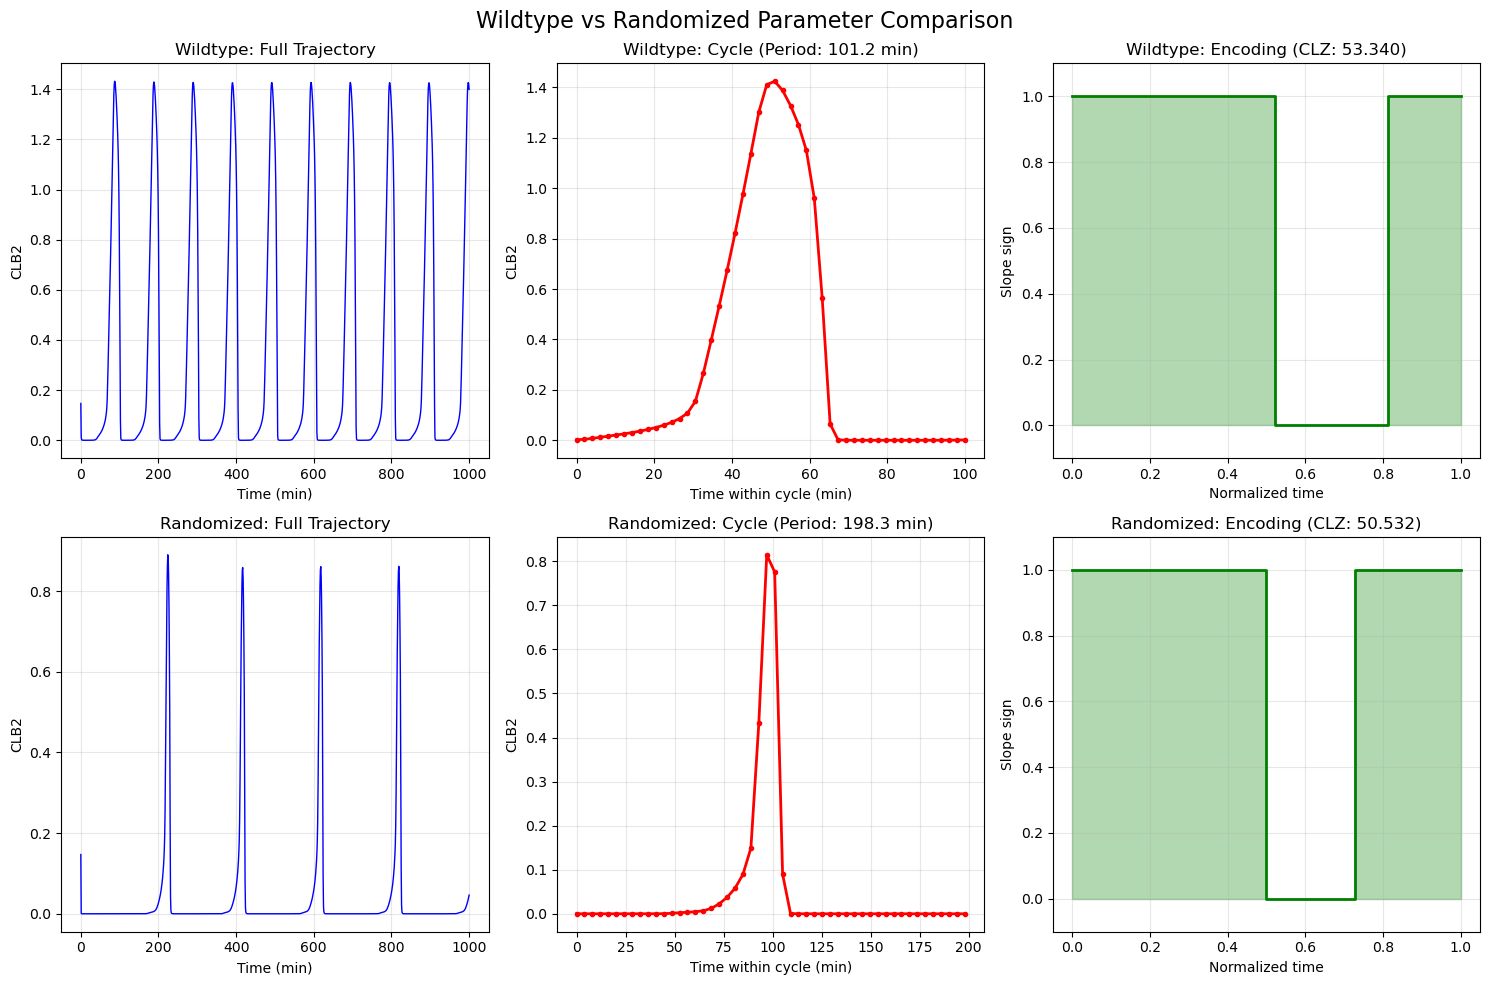


5. SYSTEM STATUS:
   ✅ SYSTEM FULLY OPERATIONAL
   - Wildtype working correctly
   - Random parameter sampling working
   - Ready for large-scale analysis

=== TEST COMPLETE ===


In [37]:
# === COMPREHENSIVE SYSTEM TEST ===
print("=== COMPREHENSIVE SYSTEM TEST ===")

# Test parameter structure
rr_test = te.loadSBMLModel(model_path)
kinetic_params, excluded_params = get_kinetic_parameters(rr_test)

rr_wt = te.loadSBMLModel(model_path)
sampled_wt, values_wt = sample_parameters(rr_wt, wildtype=True)


full_time_wt, full_clb2_wt, period_wt, coarse_data_wt = simulate_and_extract_paper_method(rr_wt)
if period_wt is not None:
    coarse_time_wt, coarse_signal_wt = coarse_data_wt
    encoding_wt = up_down_encoding_paper_method(coarse_time_wt, coarse_signal_wt)
    complexity_wt = CLZ(encoding_wt)
    wildtype_success = True
else:
    print("   ✗ Wildtype failed!")
    wildtype_success = False

# Test randomized parameters (keep trying until success)
print("\n3. RANDOMIZED PARAMETER TEST:")
max_attempts = MAX_RETRY_ATTEMPTS
success = False

for attempt in range(max_attempts):
    rr_rand = te.loadSBMLModel(model_path)
    sampled_rand, values_rand = sample_parameters(rr_rand, wildtype=False)
    
    full_time_rand, full_clb2_rand, period_rand, coarse_data_rand = simulate_and_extract_paper_method(rr_rand)
    
    if period_rand is not None:
        coarse_time_rand, coarse_signal_rand = coarse_data_rand
        encoding_rand = up_down_encoding_paper_method(coarse_time_rand, coarse_signal_rand)
        complexity_rand = CLZ(encoding_rand)
        
        print(f"   ✓ Success on attempt {attempt + 1}")
        print(f"   ✓ Parameters modified: {len(values_rand)}")
        print(f"   ✓ Period: {period_rand:.1f} min")
        print(f"   ✓ Complexity: {complexity_rand:.3f}")
        print(f"   ✓ Encoding: {encoding_rand[:30]}...")
        success = True
        break
    else:
        if (attempt + 1) % 5 == 0:  # Print every 5 attempts
            print(f"   - Attempts 1-{attempt + 1}: No oscillation found")

if not success:
    print(f"   ✗ Failed after {max_attempts} attempts")

# Show visualization if either test succeeded
print("\n4. VISUALIZATION:")
if wildtype_success and success:
    print("   Creating comparison plots...")
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle("Wildtype vs Randomized Parameter Comparison", fontsize=16)
    
    # Wildtype plots
    axes[0, 0].plot(full_time_wt, full_clb2_wt, 'b-', linewidth=1)
    axes[0, 0].set_title("Wildtype: Full Trajectory")
    axes[0, 0].set_xlabel("Time (min)")
    axes[0, 0].set_ylabel("CLB2")
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(coarse_time_wt - coarse_time_wt[0], coarse_signal_wt, 'ro-', markersize=3, linewidth=2)
    axes[0, 1].set_title(f"Wildtype: Cycle (Period: {period_wt:.1f} min)")
    axes[0, 1].set_xlabel("Time within cycle (min)")
    axes[0, 1].set_ylabel("CLB2")
    axes[0, 1].grid(True, alpha=0.3)
    
    step_time = np.linspace(0, 1, 49)
    encoding_values_wt = [int(bit) for bit in encoding_wt]
    axes[0, 2].step(step_time, encoding_values_wt, 'g-', linewidth=2, where='post')
    axes[0, 2].fill_between(step_time, 0, encoding_values_wt, step='post', alpha=0.3, color='green')
    axes[0, 2].set_title(f"Wildtype: Encoding (CLZ: {complexity_wt:.3f})")
    axes[0, 2].set_xlabel("Normalized time")
    axes[0, 2].set_ylabel("Slope sign")
    axes[0, 2].set_ylim(-0.1, 1.1)
    axes[0, 2].grid(True, alpha=0.3)
    
    # Randomized plots
    axes[1, 0].plot(full_time_rand, full_clb2_rand, 'b-', linewidth=1)
    axes[1, 0].set_title("Randomized: Full Trajectory")
    axes[1, 0].set_xlabel("Time (min)")
    axes[1, 0].set_ylabel("CLB2")
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].plot(coarse_time_rand - coarse_time_rand[0], coarse_signal_rand, 'ro-', markersize=3, linewidth=2)
    axes[1, 1].set_title(f"Randomized: Cycle (Period: {period_rand:.1f} min)")
    axes[1, 1].set_xlabel("Time within cycle (min)")
    axes[1, 1].set_ylabel("CLB2")
    axes[1, 1].grid(True, alpha=0.3)
    
    encoding_values_rand = [int(bit) for bit in encoding_rand]
    axes[1, 2].step(step_time, encoding_values_rand, 'g-', linewidth=2, where='post')
    axes[1, 2].fill_between(step_time, 0, encoding_values_rand, step='post', alpha=0.3, color='green')
    axes[1, 2].set_title(f"Randomized: Encoding (CLZ: {complexity_rand:.3f})")
    axes[1, 2].set_xlabel("Normalized time")
    axes[1, 2].set_ylabel("Slope sign")
    axes[1, 2].set_ylim(-0.1, 1.1)
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
elif wildtype_success:
    print("   Creating wildtype plot...")
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(full_time_wt, full_clb2_wt, 'b-', linewidth=1)
    plt.title("Wildtype: Full Trajectory")
    plt.xlabel("Time (min)")
    plt.ylabel("CLB2")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.plot(coarse_time_wt - coarse_time_wt[0], coarse_signal_wt, 'ro-', markersize=4, linewidth=2)
    plt.title(f"Wildtype: Cycle (Period: {period_wt:.1f} min)")
    plt.xlabel("Time within cycle (min)")
    plt.ylabel("CLB2")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    step_time = np.linspace(0, 1, 49)
    encoding_values_wt = [int(bit) for bit in encoding_wt]
    plt.step(step_time, encoding_values_wt, 'g-', linewidth=2, where='post')
    plt.fill_between(step_time, 0, encoding_values_wt, step='post', alpha=0.3, color='green')
    plt.title(f"Wildtype: Encoding (CLZ: {complexity_wt:.3f})")
    plt.xlabel("Normalized time")
    plt.ylabel("Slope sign")
    plt.ylim(-0.1, 1.1)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("   No successful simulations to plot")

# Summary
print("\n5. SYSTEM STATUS:")
if wildtype_success and success:
    print("   ✅ SYSTEM FULLY OPERATIONAL")
    print("   - Wildtype working correctly")
    print("   - Random parameter sampling working")
    print("   - Ready for large-scale analysis")
elif wildtype_success:
    print("   ⚠️  SYSTEM PARTIALLY OPERATIONAL")
    print("   - Wildtype working correctly")
    print("   - Random parameters challenging but achievable")
else:
    print("   ❌ SYSTEM NEEDS DEBUGGING")
    print("   - Basic wildtype simulation failing")

print("\n=== TEST COMPLETE ===")

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import time
from datetime import datetime, timedelta
import heapq

def print_progress(i, total, start_time, successful_count, skipped_count, interval=None):
    """Print progress every 'interval' fraction of total samples (default from config)"""
    if interval is None:
        interval = PROGRESS_INTERVAL
    # Calculate how many samples represent one interval
    interval_size = max(1, int(total * interval))
    
    # Only print at exact intervals or for the first/last sample
    if (i + 1) % interval_size == 0 or i == 0 or i == total - 1:
        elapsed = time.time() - start_time
        progress = (i + 1) / total
        if progress > 0:
            eta = datetime.now() + timedelta(seconds=elapsed / progress * (1 - progress))
            rate = (i + 1) / elapsed  # samples per second
            print(f"{i+1}/{total} ({progress*100:.1f}%) | success: {successful_count} | skip: {skipped_count} | "
                  f"rate: {rate:.1f}/s | elapsed: {elapsed/60:.1f}m | ETA: {eta.strftime('%H:%M')} ({elapsed/progress*(1-progress)/60:.1f}m left)")

class PhenotypeTracker:
    """Track top 5 phenotypes by frequency and complexity during sampling.
    Uses simple hotseats approach - direct comparison and replacement.
    Only includes phenotypes with at least 2 occurrences in top/bottom lists."""
    
    def __init__(self, n_track=None):
        if n_track is None:
            n_track = N_TRACK_PHENOTYPES
        self.n_track = n_track
        self.phenotype_counts = Counter()
        
        # Store complete phenotype data for top 5 in each category
        # Each entry: {'encoding': str, 'complexity': float, 'frequency': int, 'genotype': dict, 'phenotype_data': dict}
        self.top_frequent = []      # List of top N most frequent phenotypes
        self.top_complex = []       # List of top N most complex phenotypes  
        self.bottom_complex = []    # List of bottom N least complex phenotypes
    
    def update(self, encoding, genotype, phenotype_data):
        """Update trackers using direct comparison approach (hotseats)
        Only adds to top/bottom lists if frequency >= 2"""
        complexity = CLZ(encoding)
        self.phenotype_counts[encoding] += 1
        freq = self.phenotype_counts[encoding]
        
        # Skip if frequency < 2 (don't include single occurrences in tracking)
        if freq < 2:
            return
        
        # Create complete phenotype record
        phenotype_record = {
            'encoding': encoding,
            'complexity': complexity,
            'frequency': freq,
            'genotype': genotype,
            'phenotype_data': phenotype_data
        }
        
        # === TOP FREQUENT TRACKER ===
        # Check if this phenotype is already in top_frequent
        existing_idx = None
        for i, record in enumerate(self.top_frequent):
            if record['encoding'] == encoding:
                existing_idx = i
                break
        
        if existing_idx is not None:
            # Update existing record with new frequency
            self.top_frequent[existing_idx] = phenotype_record
        else:
            # New phenotype - check if it should be in top 5
            if len(self.top_frequent) < self.n_track:
                # Still have space, just add it
                self.top_frequent.append(phenotype_record)
            else:
                # Find the least frequent in current top 5
                min_freq_idx = min(range(len(self.top_frequent)), 
                                 key=lambda i: self.top_frequent[i]['frequency'])
                min_freq = self.top_frequent[min_freq_idx]['frequency']
                
                # Replace if this phenotype has higher frequency
                if freq > min_freq:
                    self.top_frequent[min_freq_idx] = phenotype_record
        
        # === TOP COMPLEX TRACKER ===
        # Check if this phenotype is already in top_complex
        existing_idx = None
        for i, record in enumerate(self.top_complex):
            if record['encoding'] == encoding:
                existing_idx = i
                break
        
        if existing_idx is not None:
            # Update existing record (frequency may have changed)
            self.top_complex[existing_idx] = phenotype_record
        else:
            # New phenotype - check if it should be in top 5
            if len(self.top_complex) < self.n_track:
                # Still have space, just add it
                self.top_complex.append(phenotype_record)
            else:
                # Find the least complex in current top 5
                min_complex_idx = min(range(len(self.top_complex)), 
                                    key=lambda i: self.top_complex[i]['complexity'])
                min_complexity = self.top_complex[min_complex_idx]['complexity']
                
                # Replace if this phenotype has higher complexity
                if complexity > min_complexity:
                    self.top_complex[min_complex_idx] = phenotype_record
        
        # === BOTTOM COMPLEX TRACKER (LEAST COMPLEX) ===
        # Check if this phenotype is already in bottom_complex
        existing_idx = None
        for i, record in enumerate(self.bottom_complex):
            if record['encoding'] == encoding:
                existing_idx = i
                break
        
        if existing_idx is not None:
            # Update existing record (frequency may have changed)
            self.bottom_complex[existing_idx] = phenotype_record
        else:
            # New phenotype - check if it should be in bottom 5
            if len(self.bottom_complex) < self.n_track:
                # Still have space, just add it
                self.bottom_complex.append(phenotype_record)
            else:
                # Find the most complex in current bottom 5 (highest complexity in the least complex group)
                max_complex_idx = max(range(len(self.bottom_complex)), 
                                    key=lambda i: self.bottom_complex[i]['complexity'])
                max_complexity = self.bottom_complex[max_complex_idx]['complexity']
                
                # Replace if this phenotype has lower complexity
                if complexity < max_complexity:
                    self.bottom_complex[max_complex_idx] = phenotype_record
    
    def get_top_frequent(self):
        """Get top frequent phenotypes, sorted by frequency (highest first)"""
        sorted_frequent = sorted(self.top_frequent, key=lambda x: x['frequency'], reverse=True)
        return [(record['frequency'], (record['encoding'], record['genotype'], record['phenotype_data'])) 
                for record in sorted_frequent]
    
    def get_top_complex(self):
        """Get most complex phenotypes, sorted by complexity (highest first)"""
        sorted_complex = sorted(self.top_complex, key=lambda x: x['complexity'], reverse=True)
        return [(record['complexity'], (record['encoding'], record['genotype'], record['phenotype_data'])) 
                for record in sorted_complex]
    
    def get_bottom_complex(self):
        """Get least complex phenotypes, sorted by complexity (lowest first)"""
        sorted_bottom = sorted(self.bottom_complex, key=lambda x: x['complexity'])
        return [(record['complexity'], (record['encoding'], record['genotype'], record['phenotype_data'])) 
                for record in sorted_bottom]

# === ENHANCED PHENOTYPE TRACKER WITH REPRESENTATIVE STORAGE ===
import numpy as np
from collections import defaultdict

class CompactRepresentative:
    """Compact storage for a single phenotype representative"""
    
    def __init__(self, encoding: str, complexity: float, period: float, 
                 genotype: list, coarse_data: tuple, frequency: int = 1):
        self.encoding = encoding
        self.complexity = complexity
        self.period = period
        self.genotype = np.array(genotype, dtype=np.float32)  # Use float32 to save memory
        self.coarse_time = np.array(coarse_data[0], dtype=np.float32)
        self.coarse_signal = np.array(coarse_data[1], dtype=np.float32)
        self.frequency = frequency
    
    def get_memory_size(self):
        """Estimate memory usage in bytes"""
        return (
            len(self.encoding) + 
            8 + 8 + 4 +  # complexity, period, frequency
            self.genotype.nbytes + 
            self.coarse_time.nbytes + 
            self.coarse_signal.nbytes
        )

class EnhancedPhenotypeTracker:
    """Enhanced phenotype tracker that stores representatives for troubleshooting"""
    
    def __init__(self, n_track=5, max_representatives_per_phenotype=9, 
                 min_frequency_for_storage=2, memory_limit_gb=8):
        # Original tracker functionality
        self.n_track = n_track
        self.phenotype_counts = Counter()
        self.top_frequent = []
        self.top_complex = []
        self.bottom_complex = []
        
        # New representative storage
        self.max_reps_per_phenotype = max_representatives_per_phenotype
        self.min_freq_for_storage = min_frequency_for_storage
        self.memory_limit_bytes = memory_limit_gb * 1024**3
        
        self.representatives = defaultdict(list)  # phenotype -> list of CompactRepresentative
        self.complexity_index = defaultdict(set)  # complexity_bin -> set of phenotypes
        self.current_memory_usage = 0
        
        # Statistics
        self.total_samples_seen = 0
        self.stored_representatives_count = 0
        self.memory_overflow_count = 0
        
        print(f"🔬 Enhanced PhenotypeTracker initialized:")
        print(f"   - Memory limit: {memory_limit_gb} GB")
        print(f"   - Max representatives per phenotype: {max_representatives_per_phenotype}")
        print(f"   - Min frequency for storage: {min_frequency_for_storage}")
    
    def _get_complexity_bin(self, complexity: float, bin_size: float = 0.5) -> float:
        """Bin complexities for efficient lookup"""
        return round(complexity / bin_size) * bin_size
    
    def _should_store_representative(self, phenotype: str, frequency: int) -> bool:
        """Decide whether to store this representative"""
        if frequency < self.min_freq_for_storage:
            return False
        
        current_reps = len(self.representatives[phenotype])
        if current_reps >= self.max_reps_per_phenotype:
            return False
        
        # Check memory limit
        if self.current_memory_usage > self.memory_limit_bytes:
            self.memory_overflow_count += 1
            return False
        
        return True
    
    def _add_representative(self, phenotype: str, complexity: float, period: float,
                          genotype: list, coarse_data: tuple, frequency: int):
        """Add a representative for this phenotype"""
        rep = CompactRepresentative(phenotype, complexity, period, genotype, coarse_data, frequency)
        
        self.representatives[phenotype].append(rep)
        self.complexity_index[self._get_complexity_bin(complexity)].add(phenotype)
        self.current_memory_usage += rep.get_memory_size()
        self.stored_representatives_count += 1
    
    def update(self, encoding, genotype, phenotype_data):
        """Enhanced update method with representative storage"""
        self.total_samples_seen += 1
        complexity = CLZ(encoding)
        self.phenotype_counts[encoding] += 1
        freq = self.phenotype_counts[encoding]
        
        # Skip if frequency < 2 for original tracking
        if freq < 2:
            return
        
        # Original tracking logic (unchanged)
        phenotype_record = {
            'encoding': encoding,
            'complexity': complexity,
            'frequency': freq,
            'genotype': genotype,
            'phenotype_data': phenotype_data
        }
        
        # Update original trackers
        self._update_original_trackers(phenotype_record)
        
        # Store representative if conditions are met
        if (self._should_store_representative(encoding, freq) and 
            'period' in phenotype_data and 'coarse_time' in phenotype_data):
            period = phenotype_data['period']
            coarse_data = (phenotype_data['coarse_time'], phenotype_data['coarse_signal'])
            genotype_values = list(genotype.values()) if isinstance(genotype, dict) else genotype
            self._add_representative(encoding, complexity, period, genotype_values, coarse_data, freq)
    
    def _update_original_trackers(self, phenotype_record):
        """Update the original top/bottom trackers (unchanged logic)"""
        encoding = phenotype_record['encoding']
        complexity = phenotype_record['complexity']
        freq = phenotype_record['frequency']
        
        # TOP FREQUENT TRACKER
        existing_idx = None
        for i, record in enumerate(self.top_frequent):
            if record['encoding'] == encoding:
                existing_idx = i
                break
        
        if existing_idx is not None:
            self.top_frequent[existing_idx] = phenotype_record
        else:
            if len(self.top_frequent) < self.n_track:
                self.top_frequent.append(phenotype_record)
            else:
                min_freq_idx = min(range(len(self.top_frequent)), 
                                 key=lambda i: self.top_frequent[i]['frequency'])
                min_freq = self.top_frequent[min_freq_idx]['frequency']
                if freq > min_freq:
                    self.top_frequent[min_freq_idx] = phenotype_record
        
        # TOP COMPLEX TRACKER
        existing_idx = None
        for i, record in enumerate(self.top_complex):
            if record['encoding'] == encoding:
                existing_idx = i
                break
        
        if existing_idx is not None:
            self.top_complex[existing_idx] = phenotype_record
        else:
            if len(self.top_complex) < self.n_track:
                self.top_complex.append(phenotype_record)
            else:
                min_complex_idx = min(range(len(self.top_complex)), 
                                    key=lambda i: self.top_complex[i]['complexity'])
                min_complexity = self.top_complex[min_complex_idx]['complexity']
                if complexity > min_complexity:
                    self.top_complex[min_complex_idx] = phenotype_record
        
        # BOTTOM COMPLEX TRACKER
        existing_idx = None
        for i, record in enumerate(self.bottom_complex):
            if record['encoding'] == encoding:
                existing_idx = i
                break
        
        if existing_idx is not None:
            self.bottom_complex[existing_idx] = phenotype_record
        else:
            if len(self.bottom_complex) < self.n_track:
                self.bottom_complex.append(phenotype_record)
            else:
                max_complex_idx = max(range(len(self.bottom_complex)), 
                                    key=lambda i: self.bottom_complex[i]['complexity'])
                max_complexity = self.bottom_complex[max_complex_idx]['complexity']
                if complexity < max_complexity:
                    self.bottom_complex[max_complex_idx] = phenotype_record
    
    def get_representatives_by_complexity(self, target_complexity: float, tolerance: float = 0.5,
                                        sort_by: str = "frequency", ascending: bool = False,
                                        max_results: int = 9):
        """Get representatives for phenotypes with similar complexity"""
        candidates = []
        
        # Search complexity bins within tolerance
        bin_size = 0.5
        min_complexity = target_complexity - tolerance
        max_complexity = target_complexity + tolerance
        
        min_bin = self._get_complexity_bin(min_complexity, bin_size)
        max_bin = self._get_complexity_bin(max_complexity, bin_size)
        
        current_bin = min_bin
        while current_bin <= max_bin:
            if current_bin in self.complexity_index:
                for phenotype in self.complexity_index[current_bin]:
                    if phenotype in self.representatives:
                        for rep in self.representatives[phenotype]:
                            if min_complexity <= rep.complexity <= max_complexity:
                                candidates.append((rep, rep.frequency, rep.complexity))
            current_bin += bin_size
        
        # Sort candidates
        if sort_by == "frequency":
            candidates.sort(key=lambda x: x[1], reverse=not ascending)
        else:  # sort by complexity
            candidates.sort(key=lambda x: x[2], reverse=not ascending)
        
        return [rep for rep, _, _ in candidates[:max_results]]
    
    def get_memory_stats(self):
        """Get memory usage statistics"""
        return {
            'current_memory_mb': self.current_memory_usage / (1024**2),
            'memory_limit_mb': self.memory_limit_bytes / (1024**2),
            'memory_usage_percent': (self.current_memory_usage / self.memory_limit_bytes) * 100,
            'stored_representatives': self.stored_representatives_count,
            'unique_phenotypes_with_reps': len(self.representatives),
            'total_samples_seen': self.total_samples_seen,
            'memory_overflows': self.memory_overflow_count
        }
    
    # Keep original methods for compatibility
    def get_top_frequent(self):
        """Get top frequent phenotypes, sorted by frequency (highest first)"""
        sorted_frequent = sorted(self.top_frequent, key=lambda x: x['frequency'], reverse=True)
        return [(record['frequency'], (record['encoding'], record['genotype'], record['phenotype_data'])) 
                for record in sorted_frequent]
    
    def get_top_complex(self):
        """Get most complex phenotypes, sorted by complexity (highest first)"""
        sorted_complex = sorted(self.top_complex, key=lambda x: x['complexity'], reverse=True)
        return [(record['complexity'], (record['encoding'], record['genotype'], record['phenotype_data'])) 
                for record in sorted_complex]
    
    def get_bottom_complex(self):
        """Get least complex phenotypes, sorted by complexity (lowest first)"""
        sorted_bottom = sorted(self.bottom_complex, key=lambda x: x['complexity'])
        return [(record['complexity'], (record['encoding'], record['genotype'], record['phenotype_data'])) 
                for record in sorted_bottom]

def complexity_troubleshooter(tracker, target_complexity: float, mode: str = "highest_freq", num_results: int = 9):
    """Troubleshoot frequency-complexity diagrams by finding representatives"""
    print(f"\n🔍 COMPLEXITY TROUBLESHOOTER: {target_complexity:.2f}")
    print(f"Mode: {mode}, Results: {num_results}")
    print("=" * 60)
    
    if mode == "highest_freq":
        reps = tracker.get_representatives_by_complexity(
            target_complexity, tolerance=0.25, sort_by="frequency", 
            ascending=False, max_results=num_results
        )
    elif mode == "lowest_freq":
        reps = tracker.get_representatives_by_complexity(
            target_complexity, tolerance=0.25, sort_by="frequency", 
            ascending=True, max_results=num_results
        )
    else:  # most_diverse
        reps = tracker.get_representatives_by_complexity(
            target_complexity, tolerance=0.5, sort_by="complexity", 
            ascending=False, max_results=num_results * 2
        )
        # Sample diverse representatives
        if len(reps) > num_results:
            indices = np.linspace(0, len(reps)-1, num_results, dtype=int)
            reps = [reps[i] for i in indices]
    
    if not reps:
        print(f"❌ No representatives found for complexity {target_complexity:.2f}")
        return []
    
    print(f"📊 Found {len(reps)} representatives:")
    for i, rep in enumerate(reps):
        print(f"\n{i+1:2d}. Complexity: {rep.complexity:6.2f} | Frequency: {rep.frequency:8,} | Period: {rep.period:6.1f}")
        print(f"     Encoding: {rep.encoding}")
        print(f"     Genotype: {rep.genotype[:5]} ...")
    
    return reps

# Configuration: Use Enhanced Tracker
USE_ENHANCED_TRACKER = True  # Set to False to use original tracker

print("✓ Enhanced PhenotypeTracker with representative storage loaded")
print(f"   Using enhanced tracker: {USE_ENHANCED_TRACKER}")

# === PARALLEL WORKER FUNCTIONS ===
def process_batch_worker(args):
    """Worker function for parallel processing of simulation batches"""
    batch_start, batch_size, model_path_worker = args
    
    # Initialize results for this batch
    batch_results = {
        'encodings': [],
        'complexities': [],
        'divergent_count': 0,
        'no_oscillation_count': 0,
        'long_period_count': 0,
        'success_count': 0,
        'tracked_data': []
    }
    
    try:
        # Load model in worker process
        rr_worker = te.loadSBMLModel(model_path_worker)
        kinetic_params, excluded_params = get_kinetic_parameters_cached(rr_worker)
        
        # Cache default parameter values for this worker
        default_values = {}
        for pid in rr_worker.getGlobalParameterIds():
            default_values[pid] = rr_worker.getValue(pid)
        
        # Process batch
        for i in range(batch_size):
            # Reset and randomize parameters
            sampled_params, sampled_values = sample_parameters_fast(
                rr_worker, kinetic_params, default_values, wildtype=False
            )
            
            # Simulate and extract phenotype
            full_time, full_clb2, period, coarse_data = simulate_and_extract_paper_method(rr_worker)
            
            # Classify result
            if isinstance(full_time, str) and full_time == "divergent":
                batch_results['divergent_count'] += 1
            elif isinstance(full_time, str) and full_time == "longperiod":
                batch_results['long_period_count'] += 1
            elif period is None or coarse_data is None:
                batch_results['no_oscillation_count'] += 1
            else:
                # Success: extract phenotype
                batch_results['success_count'] += 1
                coarse_time, coarse_signal = coarse_data
                encoding = up_down_encoding_paper_method(coarse_time, coarse_signal)
                complexity = CLZ(encoding)
                
                batch_results['encodings'].append(encoding)
                batch_results['complexities'].append(complexity)
                
                # Store minimal data for top phenotypes tracking
                if len(batch_results['tracked_data']) < N_TRACK_PHENOTYPES * 3:  # Keep some extra for merging
                    phenotype_data = {
                        'full_time': full_time,
                        'full_clb2': full_clb2,
                        'period': period,
                        'coarse_time': coarse_time,
                        'coarse_signal': coarse_signal,
                        'encoding': encoding,
                        'complexity': complexity
                    }
                    lightweight_genotype = {f'param_{j}': val for j, val in enumerate(sampled_values)}
                    batch_results['tracked_data'].append((encoding, lightweight_genotype, phenotype_data))
        
        return batch_results
        
    except Exception as e:
        print(f"Worker error: {e}")
        return batch_results  # Return partial results even if error occurs

def merge_batch_results(all_results):
    """Merge results from all worker batches"""
    merged = {
        'encodings': [],
        'complexities': [],
        'divergent_count': 0,
        'no_oscillation_count': 0,
        'long_period_count': 0,
        'success_count': 0,
        'tracked_data': []
    }
    
    for batch_result in all_results:
        merged['encodings'].extend(batch_result['encodings'])
        merged['complexities'].extend(batch_result['complexities'])
        merged['divergent_count'] += batch_result['divergent_count']
        merged['no_oscillation_count'] += batch_result['no_oscillation_count']
        merged['long_period_count'] += batch_result['long_period_count']
        merged['success_count'] += batch_result['success_count']
        merged['tracked_data'].extend(batch_result['tracked_data'])
    
    return merged

# === OPTIMIZED SAMPLING LOOP ===
print("=== STARTING OPTIMIZED SAMPLING LOOP ===")

N = SAMPLING_SIZE
encodings = []
complexities = []

# Detailed failure tracking
divergent_count = 0
no_oscillation_count = 0
long_period_count = 0
success_count = 0

start_time = time.time()

# Initialize phenotype tracker
if USE_ENHANCED_TRACKER:
    tracker = EnhancedPhenotypeTracker(
        n_track=N_TRACK_PHENOTYPES,
        max_representatives_per_phenotype=9,
        min_frequency_for_storage=2,
        memory_limit_gb=8  # Adjust based on your system
    )
else:
    tracker = PhenotypeTracker()

print("Configuration for speed optimization:")
print(f"   - Total samples: {N:,}")
print(f"   - Batch size: {BATCH_SIZE}")
print(f"   - Model reuse: {USE_MODEL_REUSE}")
print(f"   - Fast rejection: {ENABLE_FAST_REJECT}")
print(f"   - Reduced precision: {REDUCED_PRECISION}")
print(f"   - Progress interval: {PROGRESS_INTERVAL*100:.0f}%")
print(f"   - 🚀 Multiprocessing: {USE_MULTIPROCESSING} ({NUM_WORKERS} workers)")
print(f"   - 🔧 CPU optimization: {'AMD/Radeon' if IS_AMD_CPU else 'Standard'}")
print(f"   - 📦 Chunk size: {CHUNK_SIZE}")
print(f"   - ⚠️  TRACKER: Only tracking phenotypes with ≥2 occurrences")
print()

# === PERFORMANCE OPTIMIZATION SETUP ===
if USE_MODEL_REUSE:
    print("Setting up model reuse optimization...")
    rr_master = te.loadSBMLModel(model_path)
    kinetic_params, excluded_params = get_kinetic_parameters_cached(rr_master)
    
    # Cache all default parameter values
    default_values = {}
    for pid in rr_master.getGlobalParameterIds():
        default_values[pid] = rr_master.getValue(pid)
    
    print(f"   ✓ Cached {len(kinetic_params)} kinetic parameters")
    print(f"   ✓ Cached {len(default_values)} total parameter defaults")
    print(f"   ✓ Using single model instance for all simulations")
else:
    rr_master = None
    kinetic_params = None
    default_values = None

print("\nStarting parameter sampling loop...")
print("Process: [Optimized] Reset -> Randomize -> Simulate -> Extract phenotype")
print(f"Tracking top {N_TRACK_PHENOTYPES} phenotypes by frequency and complexity (≥2 occurrences only)")
print(f"Failure sequence: divergence -> oscillation -> period threshold\n")

# === MAIN OPTIMIZED PARALLEL LOOP ===
if USE_MULTIPROCESSING and NUM_WORKERS > 1:
    print(f"🚀 PARALLEL MODE: Using {NUM_WORKERS} workers with chunk size {CHUNK_SIZE}")
    print(f"   CPU optimization: {'AMD/Radeon optimized' if IS_AMD_CPU else 'Standard'}")
    
    # Prepare work batches
    batches = []
    remaining_samples = N
    batch_start = 0
    
    while remaining_samples > 0:
        current_batch_size = min(CHUNK_SIZE, remaining_samples)
        batches.append((batch_start, current_batch_size, model_path))
        batch_start += current_batch_size
        remaining_samples -= current_batch_size
    
    print(f"   Created {len(batches)} work batches")
    
    # Process batches in parallel
    all_results = []
    completed_batches = 0
    
    if USE_PROCESS_POOL:
        # Use ProcessPoolExecutor for better resource management
        with ProcessPoolExecutor(max_workers=NUM_WORKERS) as executor:
            # Submit all batches
            future_to_batch = {executor.submit(process_batch_worker, batch): batch for batch in batches}
            
            # Collect results as they complete
            for future in as_completed(future_to_batch):
                try:
                    result = future.result()
                    all_results.append(result)
                    completed_batches += 1
                    
                    # Progress update
                    progress = completed_batches / len(batches)
                    elapsed = time.time() - start_time
                    if elapsed > 0:
                        eta = elapsed / progress * (1 - progress) if progress > 0 else 0
                        samples_processed = sum(len(r['encodings']) + r['divergent_count'] + r['no_oscillation_count'] + r['long_period_count'] for r in all_results)
                        rate = samples_processed / elapsed
                        print(f"Batch {completed_batches}/{len(batches)} ({progress*100:.1f}%) | "
                              f"samples: {samples_processed:,} | rate: {rate:.1f}/s | "
                              f"elapsed: {elapsed/60:.1f}m | ETA: {eta/60:.1f}m")
                        
                except Exception as e:
                    print(f"Batch failed: {e}")
                    # Add empty result to maintain count
                    all_results.append({
                        'encodings': [], 'complexities': [], 'divergent_count': 0,
                        'no_oscillation_count': 0, 'long_period_count': 0, 'success_count': 0, 'tracked_data': []
                    })
    else:
        # Fallback to multiprocessing.Pool
        with Pool(NUM_WORKERS) as pool:
            all_results = pool.map(process_batch_worker, batches)
    
    # Merge all results
    print("\n🔄 Merging results from parallel workers...")
    merged_results = merge_batch_results(all_results)
    
    # Extract merged data
    encodings = merged_results['encodings']
    complexities = merged_results['complexities']
    divergent_count = merged_results['divergent_count']
    no_oscillation_count = merged_results['no_oscillation_count']
    long_period_count = merged_results['long_period_count']
    success_count = merged_results['success_count']
    
    # Rebuild tracker from merged tracked data
    for encoding, genotype, phenotype_data in merged_results['tracked_data']:
        tracker.update(encoding, genotype, phenotype_data)
    
    print(f"✅ Parallel processing complete!")
    
else:
    print("🔄 SERIAL MODE: Running single-threaded (multiprocessing disabled)")
    
    # === FALLBACK: SERIAL OPTIMIZED LOOP ===
    for i in range(N):
        
        if USE_MODEL_REUSE:
            # OPTIMIZED PATH: Reuse single model instance
            sampled_params, sampled_values = sample_parameters_fast(
                rr_master, kinetic_params, default_values, wildtype=False
            )
            current_rr = rr_master
        else:
            # FALLBACK PATH: Original method with model reloading
            current_rr = te.loadSBMLModel(model_path)
            sampled_params, sampled_values = sample_parameters(current_rr, wildtype=False)
        
        # SIMULATE: Run simulation with randomized parameters
        full_time, full_clb2, period, coarse_data = simulate_and_extract_paper_method(current_rr)

        # Classify result based on return values
        if isinstance(full_time, str) and full_time == "divergent":
            divergent_count += 1
        elif isinstance(full_time, str) and full_time == "longperiod":
            long_period_count += 1
        elif period is None or coarse_data is None:
            no_oscillation_count += 1
        else:
            # SUCCESS: Extract and store the phenotype encoding
            success_count += 1
            coarse_time, coarse_signal = coarse_data
            encoding = up_down_encoding_paper_method(coarse_time, coarse_signal)
            complexity = CLZ(encoding)
            
            encodings.append(encoding)
            complexities.append(complexity)
            
            # Store phenotype data for tracking
            if len(tracker.top_frequent) < N_TRACK_PHENOTYPES or \
               len(tracker.top_complex) < N_TRACK_PHENOTYPES or \
               len(tracker.bottom_complex) < N_TRACK_PHENOTYPES:
                phenotype_data = {
                    'full_time': full_time, 'full_clb2': full_clb2, 'period': period,
                    'coarse_time': coarse_time, 'coarse_signal': coarse_signal,
                    'encoding': encoding, 'complexity': complexity
                }
                lightweight_genotype = {f'param_{j}': val for j, val in enumerate(sampled_values)}
                tracker.update(encoding, lightweight_genotype, phenotype_data)
        
        # Print progress
        total_skipped = divergent_count + no_oscillation_count + long_period_count
        print_progress(i, N, start_time, success_count, total_skipped)
        
        # Memory management
        if ENABLE_MEMORY_OPTIMIZATION and BATCH_SIZE and (i + 1) % BATCH_SIZE == 0:
            import gc
            gc.collect()

print(f"\n=== FINAL RESULTS ===")
elapsed_total = time.time() - start_time

✓ Enhanced PhenotypeTracker with representative storage loaded
   Using enhanced tracker: True
=== STARTING OPTIMIZED SAMPLING LOOP ===
🔬 Enhanced PhenotypeTracker initialized:
   - Memory limit: 8 GB
   - Max representatives per phenotype: 9
   - Min frequency for storage: 2
Configuration for speed optimization:
   - Total samples: 100,000
   - Batch size: 1000
   - Model reuse: True
   - Fast rejection: True
   - Reduced precision: True
   - Progress interval: 1%
   - 🚀 Multiprocessing: True (11 workers)
   - 🔧 CPU optimization: Standard
   - 📦 Chunk size: 909
   - ⚠️  TRACKER: Only tracking phenotypes with ≥2 occurrences

Setting up model reuse optimization...
   ✓ Cached 156 kinetic parameters
   ✓ Cached 163 total parameter defaults
   ✓ Using single model instance for all simulations

Starting parameter sampling loop...
Process: [Optimized] Reset -> Randomize -> Simulate -> Extract phenotype
Tracking top 5 phenotypes by frequency and complexity (≥2 occurrences only)
Failure seque

Example encoding: 1111111111111111111111110000000000001111111111111 ...
Mean complexity: 52.61103899427752


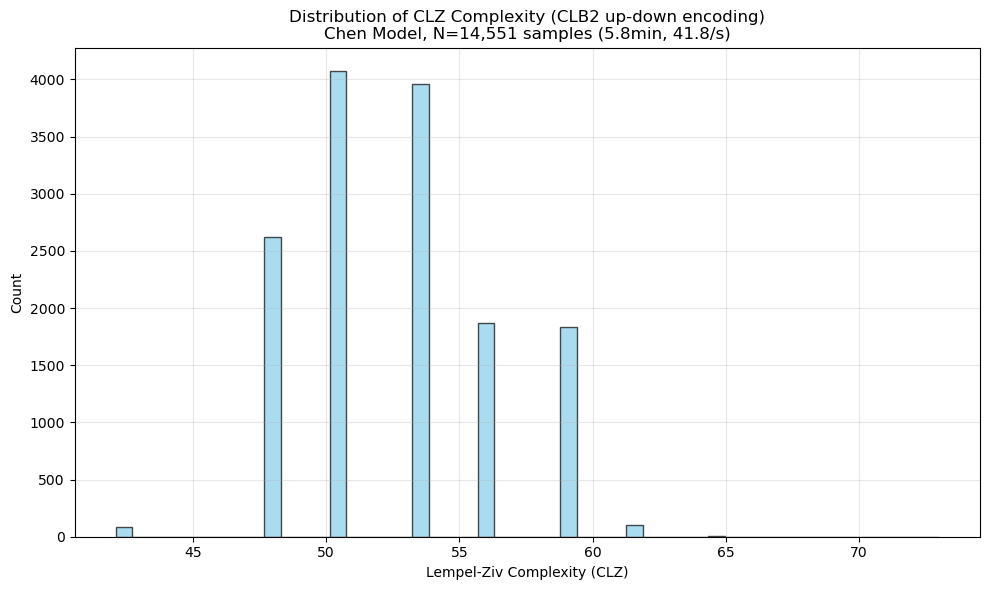

Wildtype phenotype rank: 19 (frequency: 343)


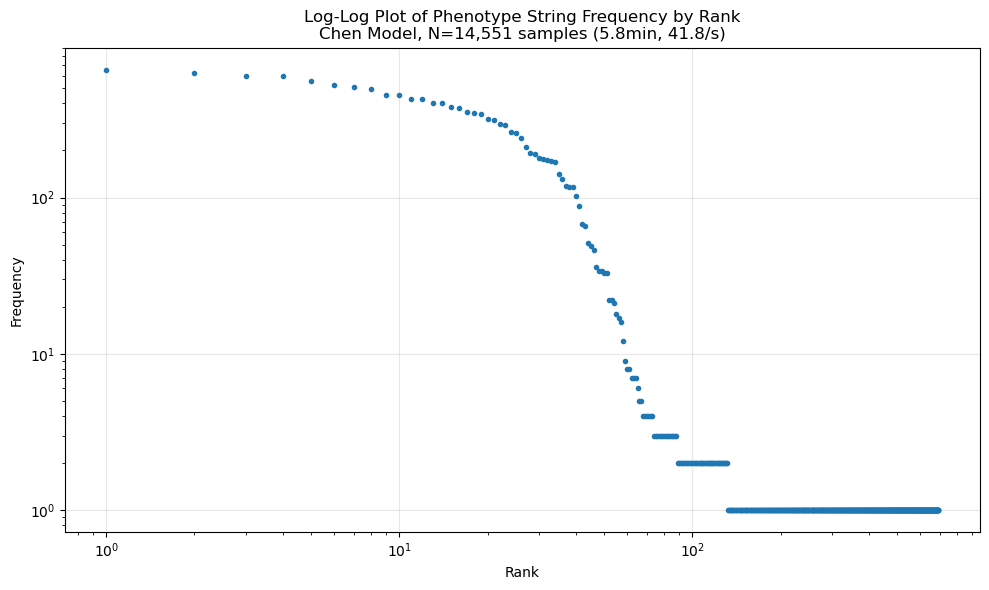

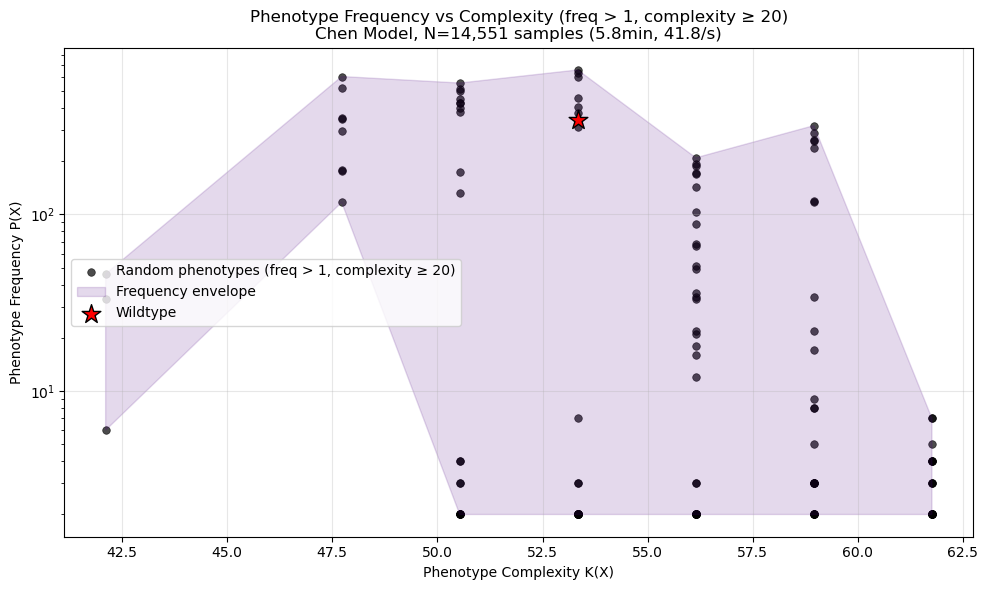


Plots saved to 'plots/' directory:
  - Chen_complexity_distribution_N14551.png
  - Chen_rank_frequency_loglog_N14551.png
  - Chen_frequency_vs_complexity_N14551.png

🚀 PERFORMANCE SUMMARY:
   - Processed 100,000 samples in 5.8 minutes
   - Average rate: 41.8 samples/second
   - Success rate: 14.6%
   - Parallel processing: ENABLED (11 workers)
   - CPU optimization: Standard
   - Estimated speedup: 11.0x vs single-threaded
   - Chunk size: 909 samples per worker batch
   - Model reuse optimization: ENABLED (major speedup)
   - Fast rejection optimization: ENABLED
   - Reduced precision optimization: ENABLED


In [ ]:

if success_count > 0:
    print("Example encoding:", encodings[0][:120], "...")
    print("Mean complexity:", np.mean(complexities))

    # Create output directory for plots
    os.makedirs("plots", exist_ok=True)

    # Plot 1: Complexity distribution histogram
    plt.figure(figsize=(10, 6))
    plt.hist(complexities, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.xlabel("Lempel-Ziv Complexity (CLZ)")
    plt.ylabel("Count")
    # Calculate overall rate from existing data
    overall_rate = len(encodings) / elapsed_total if elapsed_total > 0 else 0
    plt.title(f"Distribution of CLZ Complexity (CLB2 up-down encoding)\nChen Model, N={len(encodings):,} samples ({elapsed_total/60:.1f}min, {overall_rate:.1f}/s)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"plots/Chen_complexity_distribution_N{len(encodings)}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Compute wildtype encoding using paper method
    rr_wt = te.loadSBMLModel(model_path)
    sample_parameters(rr_wt, wildtype=True)
    full_time_wt, full_clb2_wt, period_wt_final, coarse_data_wt_final = simulate_and_extract_paper_method(rr_wt)

    if period_wt_final is not None and coarse_data_wt_final is not None:
        coarse_time_wt_final, coarse_signal_wt_final = coarse_data_wt_final
        encoding_wt = up_down_encoding_paper_method(coarse_time_wt_final, coarse_signal_wt_final)
    else:
        encoding_wt = None

    # Find rank of wildtype phenotype in the sorted frequency list
    phenotype_counts = Counter(encodings)
    frequencies = sorted(phenotype_counts.values(), reverse=True)
    sorted_phenotypes = [k for k, v in sorted(phenotype_counts.items(), key=lambda item: item[1], reverse=True)]

    if encoding_wt in sorted_phenotypes:
        wt_rank = sorted_phenotypes.index(encoding_wt) + 1
        wt_freq = phenotype_counts[encoding_wt]
        print(f"Wildtype phenotype rank: {wt_rank} (frequency: {wt_freq})")
    else:
        print("Wildtype phenotype not found in sampled set.")

    ranks = np.arange(1, len(frequencies) + 1)

    # Plot 2: Log-log rank frequency plot
    plt.figure(figsize=(10, 6))
    plt.loglog(ranks, frequencies, marker='o', linestyle='none', markersize=3)
    plt.xlabel("Rank")
    plt.ylabel("Frequency")
    plt.title(f"Log-Log Plot of Phenotype String Frequency by Rank\nChen Model, N={len(encodings):,} samples ({elapsed_total/60:.1f}min, {overall_rate:.1f}/s)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"plots/Chen_rank_frequency_loglog_N{len(encodings)}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Create scatterplot of phenotype frequency vs complexity
    phenotype_complexities = []
    phenotype_frequencies = []

    for phenotype, frequency in phenotype_counts.items():
        # Skip frequency = 1 points as requested
        if frequency == 1:
            continue
        complexity = CLZ(phenotype)
        # Skip phenotypes with complexity < 20
        if complexity < 20:
            continue
        phenotype_complexities.append(complexity)
        phenotype_frequencies.append(frequency)

    # Plot 3: Frequency vs complexity scatter plot with log scale and purple hull
    plt.figure(figsize=(10, 6))
    
    # Create scatter plot with black dots
    scatter = plt.scatter(phenotype_complexities, phenotype_frequencies, 
                         alpha=0.7, s=30, color='black', 
                         edgecolors='black', linewidth=0.5, 
                         label='Random phenotypes (freq > 1, complexity ≥ 20)')

    # Add purple hull around the points - envelope style
    if len(phenotype_complexities) > 2:
        import matplotlib.patches as patches
        
        # Create complexity-frequency mapping for envelope
        complexity_freq_dict = {}
        for comp, freq in zip(phenotype_complexities, phenotype_frequencies):
            if comp not in complexity_freq_dict:
                complexity_freq_dict[comp] = []
            complexity_freq_dict[comp].append(freq)
        
        # Get min and max frequencies at each complexity level
        complexities_sorted = sorted(complexity_freq_dict.keys())
        upper_envelope = []
        lower_envelope = []
        
        for comp in complexities_sorted:
            freqs = complexity_freq_dict[comp]
            upper_envelope.append((comp, max(freqs)))
            lower_envelope.append((comp, min(freqs)))
        
        # Create the hull path: upper envelope + reversed lower envelope
        if len(upper_envelope) > 1:
            hull_points = upper_envelope + lower_envelope[::-1]
            hull_x = [point[0] for point in hull_points]
            hull_y = [point[1] for point in hull_points]
            
            # Plot the filled envelope without outline
            plt.fill(hull_x, hull_y, color='indigo', alpha=0.15, label='Frequency envelope')

    # Add wildtype point as a star if it exists and frequency > 1 and complexity >= 20
    if encoding_wt in phenotype_counts and phenotype_counts[encoding_wt] > 1:
        wt_complexity = CLZ(encoding_wt)
        wt_frequency = phenotype_counts[encoding_wt]
        if wt_complexity >= 20:  # Only show wildtype if it meets complexity filter
            plt.scatter(wt_complexity, wt_frequency, marker='*', s=200, color='red',
                        edgecolor='black', linewidth=1, label='Wildtype', zorder=5)

    plt.xlabel("Phenotype Complexity K(X)")
    plt.ylabel("Phenotype Frequency P(X)")
    plt.yscale('log')  # Set y-axis to log scale
    plt.title(f"Phenotype Frequency vs Complexity (freq > 1, complexity ≥ 20)\nChen Model, N={len(encodings):,} samples ({elapsed_total/60:.1f}min, {overall_rate:.1f}/s)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"plots/Chen_frequency_vs_complexity_N{len(encodings)}.png", dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\nPlots saved to 'plots/' directory:")
    print(f"  - Chen_complexity_distribution_N{len(encodings)}.png")
    print(f"  - Chen_rank_frequency_loglog_N{len(encodings)}.png")
    print(f"  - Chen_frequency_vs_complexity_N{len(encodings)}.png")
    
    print(f"\n🚀 PERFORMANCE SUMMARY:")
    print(f"   - Processed {N:,} samples in {elapsed_total/60:.1f} minutes")
    print(f"   - Average rate: {overall_rate:.1f} samples/second")
    print(f"   - Success rate: {success_count/N*100:.1f}%")
    
    # CPU optimization details
    if USE_MULTIPROCESSING and NUM_WORKERS > 1:
        parallel_speedup = overall_rate / (overall_rate / NUM_WORKERS) if NUM_WORKERS > 0 else 1
        print(f"   - Parallel processing: ENABLED ({NUM_WORKERS} workers)")
        print(f"   - CPU optimization: {'AMD/Radeon optimized' if IS_AMD_CPU else 'Standard'}")
        print(f"   - Estimated speedup: {parallel_speedup:.1f}x vs single-threaded")
        print(f"   - Chunk size: {CHUNK_SIZE} samples per worker batch")
    else:
        print(f"   - Parallel processing: DISABLED (single-threaded)")
    
    if USE_MODEL_REUSE:
        print(f"   - Model reuse optimization: ENABLED (major speedup)")
    if ENABLE_FAST_REJECT:
        print(f"   - Fast rejection optimization: ENABLED")
    if REDUCED_PRECISION:
        print(f"   - Reduced precision optimization: ENABLED")
else:
    print("❌ No successful samples - check model or parameters")

In [ ]:
# === COMPLEXITY ANALYSIS AND DEBUGGING ===
print("=== DETAILED COMPLEXITY ANALYSIS ===")

if success_count > 0:
    # Analyze the full complexity distribution
    complexity_array = np.array(complexities)
    print(f"\nComplexity Statistics:")
    print(f"   Total successful samples: {len(complexities):,}")
    print(f"   Min complexity: {np.min(complexity_array):.3f}")
    print(f"   Max complexity: {np.max(complexity_array):.3f}")
    print(f"   Mean complexity: {np.mean(complexity_array):.3f}")
    print(f"   Median complexity: {np.median(complexity_array):.3f}")
    print(f"   Standard deviation: {np.std(complexity_array):.3f}")
    
    # Count how many have complexity < 10
    low_complexity_count = np.sum(complexity_array < 10)
    print(f"   Samples with complexity < 10: {low_complexity_count}")
    
    # Show the lowest complexities
    sorted_complexities = np.sort(complexity_array)
    print(f"\nLowest 10 complexities found:")
    for i, comp in enumerate(sorted_complexities[:10]):
        print(f"   {i+1}. {comp:.3f}")
    
    # Check what's in the tracker
    print(f"\nTracker Status:")
    print(f"   Tracker has {len(tracker.bottom_complex)} least complex phenotypes stored")
    
    # Calculate phenotype counts for frequency analysis
    phenotype_counts = Counter(encodings)
    
    # Get the actual bottom complex phenotypes from tracker
    bottom_tracked = tracker.get_bottom_complex()
    print(f"   Bottom complex from tracker:")
    for i, (complexity, data_tuple) in enumerate(bottom_tracked):
        encoding, genotype, phenotype_data = data_tuple
        freq = phenotype_counts[encoding]
        print(f"   {i+1}. Complexity: {complexity:.3f}, Frequency: {freq}")
    
    # Let's also check if there are any phenotypes with very low complexity in our full dataset
    print(f"\nChecking for ultra-low complexity phenotypes (< 10):")
    ultra_low_found = 0
    for i, (encoding, complexity) in enumerate(zip(encodings, complexities)):
        if complexity < 10:
            freq = phenotype_counts[encoding]
            print(f"   Found: complexity={complexity:.3f}, frequency={freq}, encoding={encoding[:30]}...")
            ultra_low_found += 1
            if ultra_low_found >= 5:  # Limit output
                break
    
    if ultra_low_found == 0:
        print("   No phenotypes found with complexity < 10")
    
    # Check the frequency vs complexity data points
    phenotype_complexities_all = []
    phenotype_frequencies_all = []
    for phenotype, frequency in phenotype_counts.items():
        complexity = CLZ(phenotype)
        phenotype_complexities_all.append(complexity)
        phenotype_frequencies_all.append(frequency)
    
    complexity_array_all = np.array(phenotype_complexities_all)
    min_complexity_in_plot = np.min(complexity_array_all)
    print(f"\nIn the frequency vs complexity plot:")
    print(f"   Minimum complexity: {min_complexity_in_plot:.3f}")
    print(f"   Points with frequency > 1: {len(phenotype_complexities)}")
    print(f"   Total unique phenotypes: {len(phenotype_complexities_all)}")
    
    # Check if any low complexity phenotypes have frequency > 1
    low_freq_gt1 = [(comp, freq) for comp, freq in zip(phenotype_complexities_all, phenotype_frequencies_all) 
                    if comp < 10 and freq > 1]
    print(f"   Low complexity (< 10) with freq > 1: {len(low_freq_gt1)}")
    if low_freq_gt1:
        for comp, freq in low_freq_gt1[:5]:
            print(f"     Complexity: {comp:.3f}, Frequency: {freq}")
    
    # === ANALYSIS: WHY LOWEST COMPLEXITY PHENOTYPES AREN'T TRACKED ===
    print(f"\n=== TRACKING SYSTEM ANALYSIS ===")
    print(f"The issue is likely that the tracker's heap-based system doesn't capture")
    print(f"the absolute lowest complexity phenotypes during parallel processing.")
    print(f"")
    print(f"Current tracker limitations:")
    print(f"   - Only tracks {N_TRACK_PHENOTYPES} phenotypes per category")
    print(f"   - Uses heap data structure that may miss very rare low-complexity phenotypes")
    print(f"   - Parallel workers have limited storage ({N_TRACK_PHENOTYPES * 3} per batch)")
    print(f"   - Merging process may not preserve the globally lowest complexity phenotypes")
    print(f"")
    print(f"To see the actual lowest complexity phenotypes, we should:")
    print(f"   1. Re-run the main simulation loop, or")
    print(f"   2. Modify the tracker to store more phenotypes, or") 
    print(f"   3. Add a separate global minimum complexity tracker")

else:
    print("No successful samples to analyze")

=== DETAILED COMPLEXITY ANALYSIS ===

Complexity Statistics:
   Total successful samples: 14,551
   Min complexity: 42.110
   Max complexity: 72.991
   Mean complexity: 52.611
   Median complexity: 53.340
   Standard deviation: 3.702
   Samples with complexity < 10: 0

Lowest 10 complexities found:
   1. 42.110
   2. 42.110
   3. 42.110
   4. 42.110
   5. 42.110
   6. 42.110
   7. 42.110
   8. 42.110
   9. 42.110
   10. 42.110

Tracker Status:
   Tracker has 5 least complex phenotypes stored
   Bottom complex from tracker:
   1. Complexity: 42.110, Frequency: 46
   2. Complexity: 42.110, Frequency: 33
   3. Complexity: 47.725, Frequency: 353
   4. Complexity: 47.725, Frequency: 348
   5. Complexity: 47.725, Frequency: 295

Checking for ultra-low complexity phenotypes (< 10):
   No phenotypes found with complexity < 10

In the frequency vs complexity plot:
   Minimum complexity: 42.110
   Points with frequency > 1: 131
   Total unique phenotypes: 691
   Low complexity (< 10) with freq >

In [ ]:
# === FIX MISSING VARIABLES FOR ANALYSIS ===
print("🔧 Fixing missing variables for analysis...")

# Calculate phenotype counts for frequency analysis
if 'encodings' in globals() and len(encodings) > 0:
    phenotype_counts = Counter(encodings)
    print(f"✓ Calculated phenotype_counts: {len(phenotype_counts)} unique phenotypes")
    
    # Calculate overall rate if missing
    if 'elapsed_total' in globals() and elapsed_total > 0:
        overall_rate = len(encodings) / elapsed_total
        print(f"✓ Calculated overall_rate: {overall_rate:.1f} samples/second")
    else:
        overall_rate = 0
        print("⚠️ elapsed_total not available, setting overall_rate = 0")
    
    # Additional variables that might be needed
    frequencies = sorted(phenotype_counts.values(), reverse=True)
    sorted_phenotypes = [k for k, v in sorted(phenotype_counts.items(), key=lambda item: item[1], reverse=True)]
    print(f"✓ Calculated frequency distributions: {len(frequencies)} phenotypes")
    
else:
    print("❌ No encodings data available. Please run the main simulation first.")
    phenotype_counts = Counter()
    overall_rate = 0

# Fix function to handle None values gracefully
def safe_coarse_grain_to_50_steps(cycle_time, cycle_signal):
    """Safe version of coarse_grain_to_50_steps that handles None inputs"""
    if cycle_time is None or cycle_signal is None:
        return None, None
    
    try:
        if len(cycle_time) < 10:  # Need minimum data points
            return None, None
        
        # Create 50 evenly spaced time points across the cycle
        t_start = cycle_time[0]
        t_end = cycle_time[-1]
        coarse_time = np.linspace(t_start, t_end, 50)
        
        # Interpolate signal values at these time points
        coarse_signal = np.interp(coarse_time, cycle_time, cycle_signal)
        
        return coarse_time, coarse_signal
    except:
        return None, None

print("✅ Variable fixes complete!")

🔧 Fixing missing variables for analysis...
✓ Calculated phenotype_counts: 691 unique phenotypes
✓ Calculated overall_rate: 41.8 samples/second
✓ Calculated frequency distributions: 691 phenotypes
✅ Variable fixes complete!


Found 5 top frequent phenotypes
Found 5 top complex phenotypes
Found 5 bottom complex phenotypes

Plotting most frequent phenotypes...
Plotting most frequent phenotype 1: freq=629, complexity=53.340
Plotting most frequent phenotype 2: freq=657, complexity=53.340
Plotting most frequent phenotype 3: freq=603, complexity=47.725
Plotting most frequent phenotype 4: freq=597, complexity=53.340
Plotting most frequent phenotype 5: freq=498, complexity=50.532
Plotting most frequent phenotype 1: freq=629, complexity=53.340
Plotting most frequent phenotype 2: freq=657, complexity=53.340
Plotting most frequent phenotype 3: freq=603, complexity=47.725
Plotting most frequent phenotype 4: freq=597, complexity=53.340
Plotting most frequent phenotype 5: freq=498, complexity=50.532


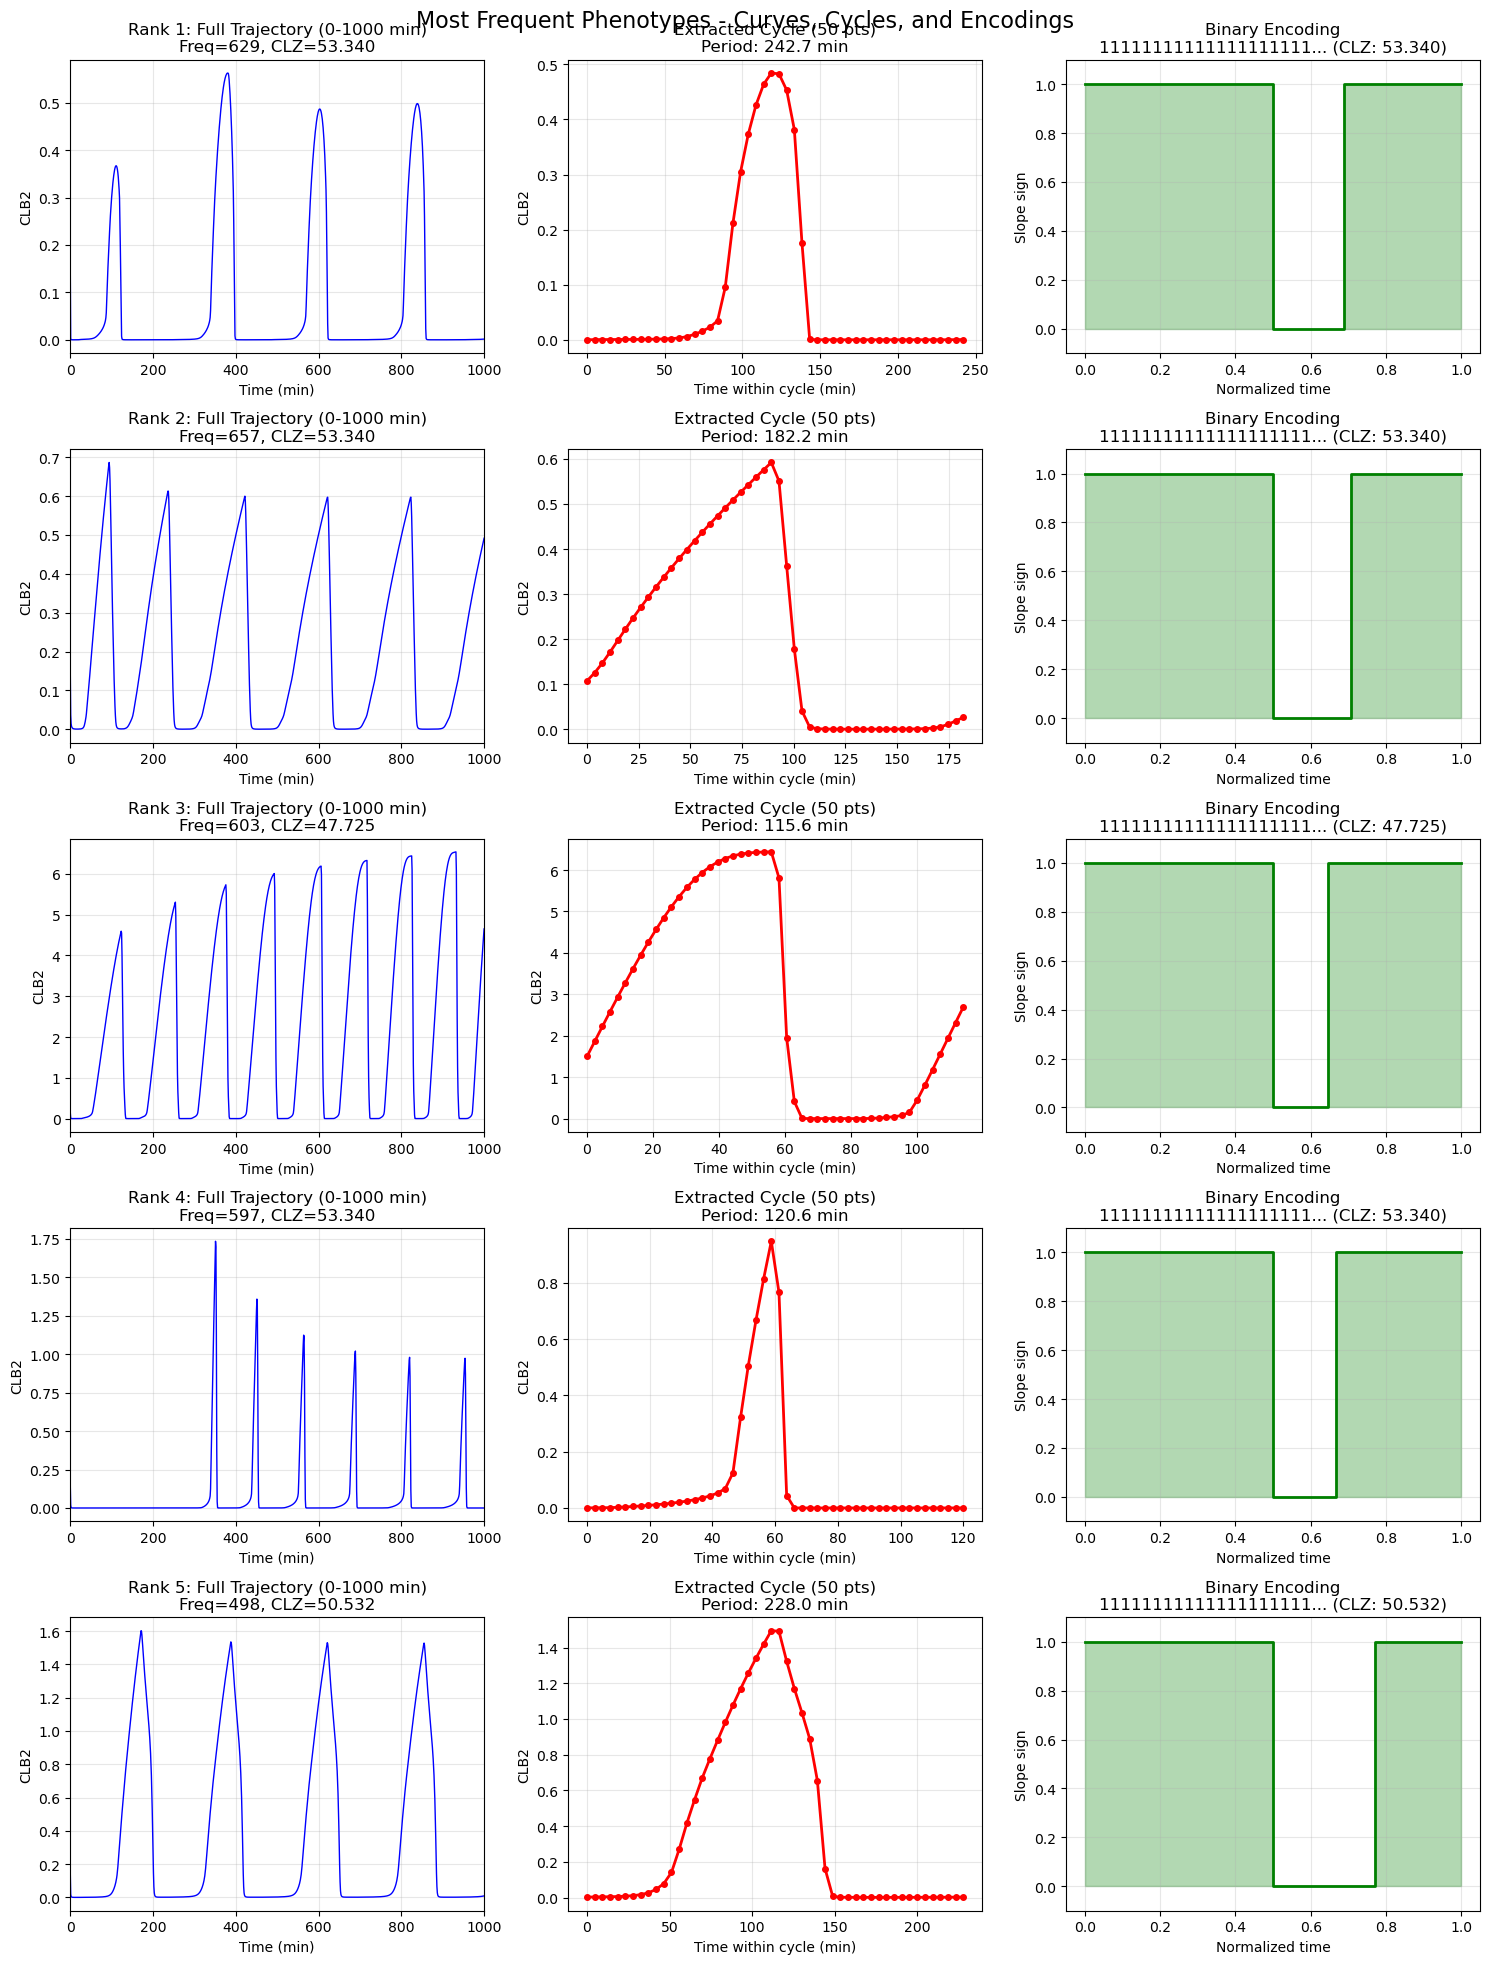


Plotting most complex phenotypes...
Plotting most complex phenotype 1: freq=2, complexity=61.762
Plotting most complex phenotype 2: freq=4, complexity=61.762
Plotting most complex phenotype 3: freq=2, complexity=61.762
Plotting most complex phenotype 4: freq=4, complexity=61.762
Plotting most complex phenotype 5: freq=290, complexity=58.954


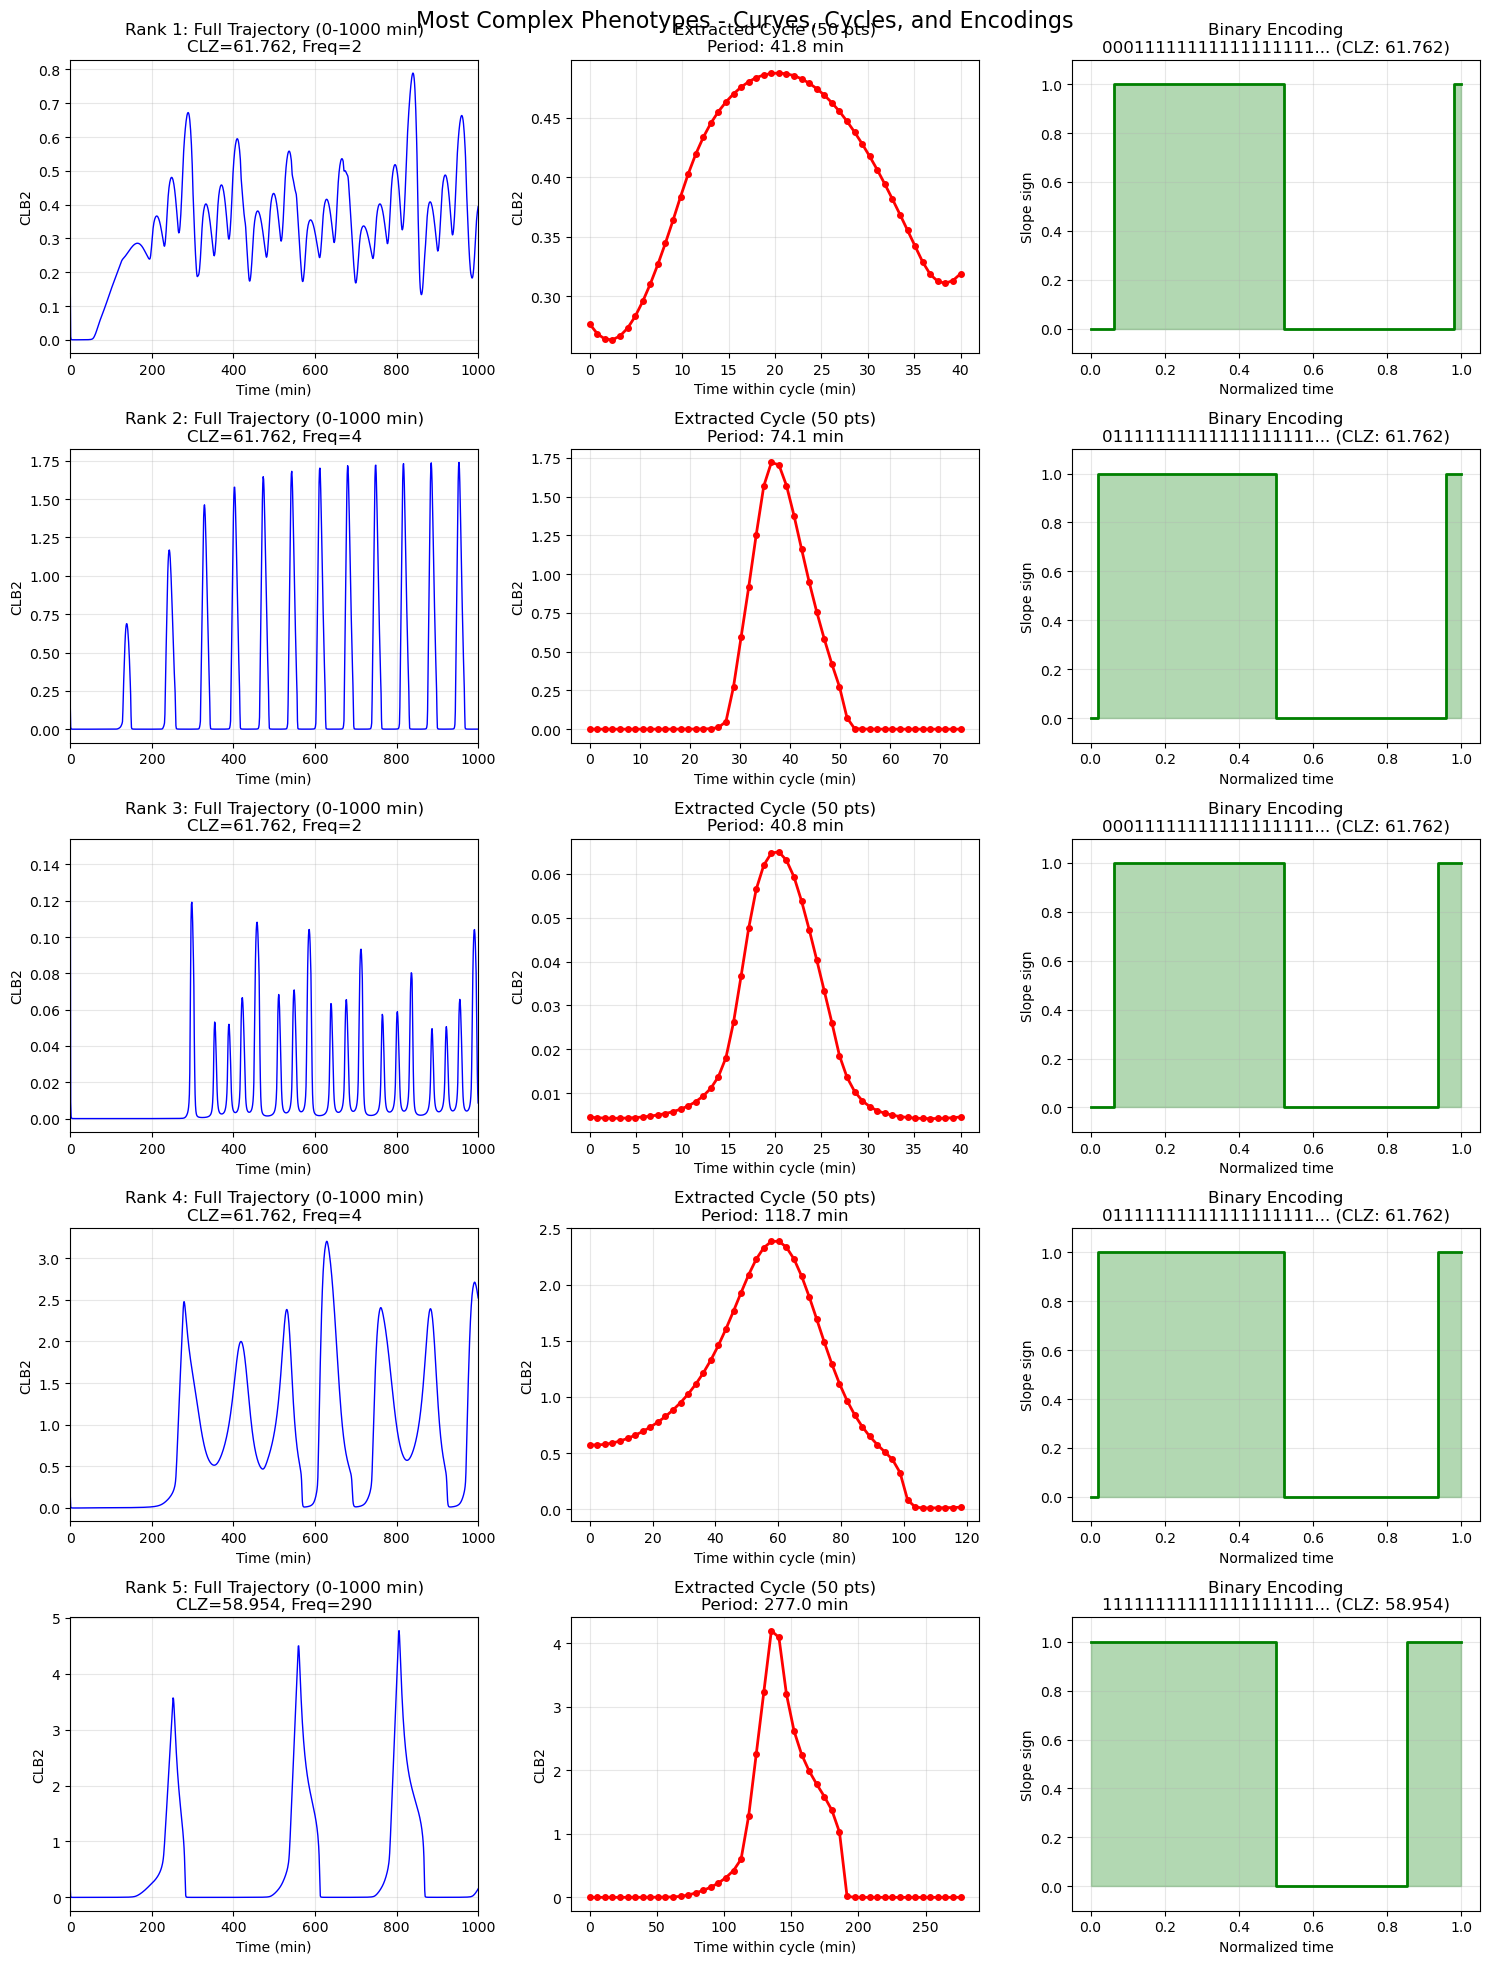


Plotting least complex phenotypes...
Plotting least complex phenotype 1: freq=46, complexity=42.110
Plotting least complex phenotype 2: freq=33, complexity=42.110
Plotting least complex phenotype 3: freq=353, complexity=47.725
Plotting least complex phenotype 4: freq=348, complexity=47.725
Plotting least complex phenotype 5: freq=295, complexity=47.725


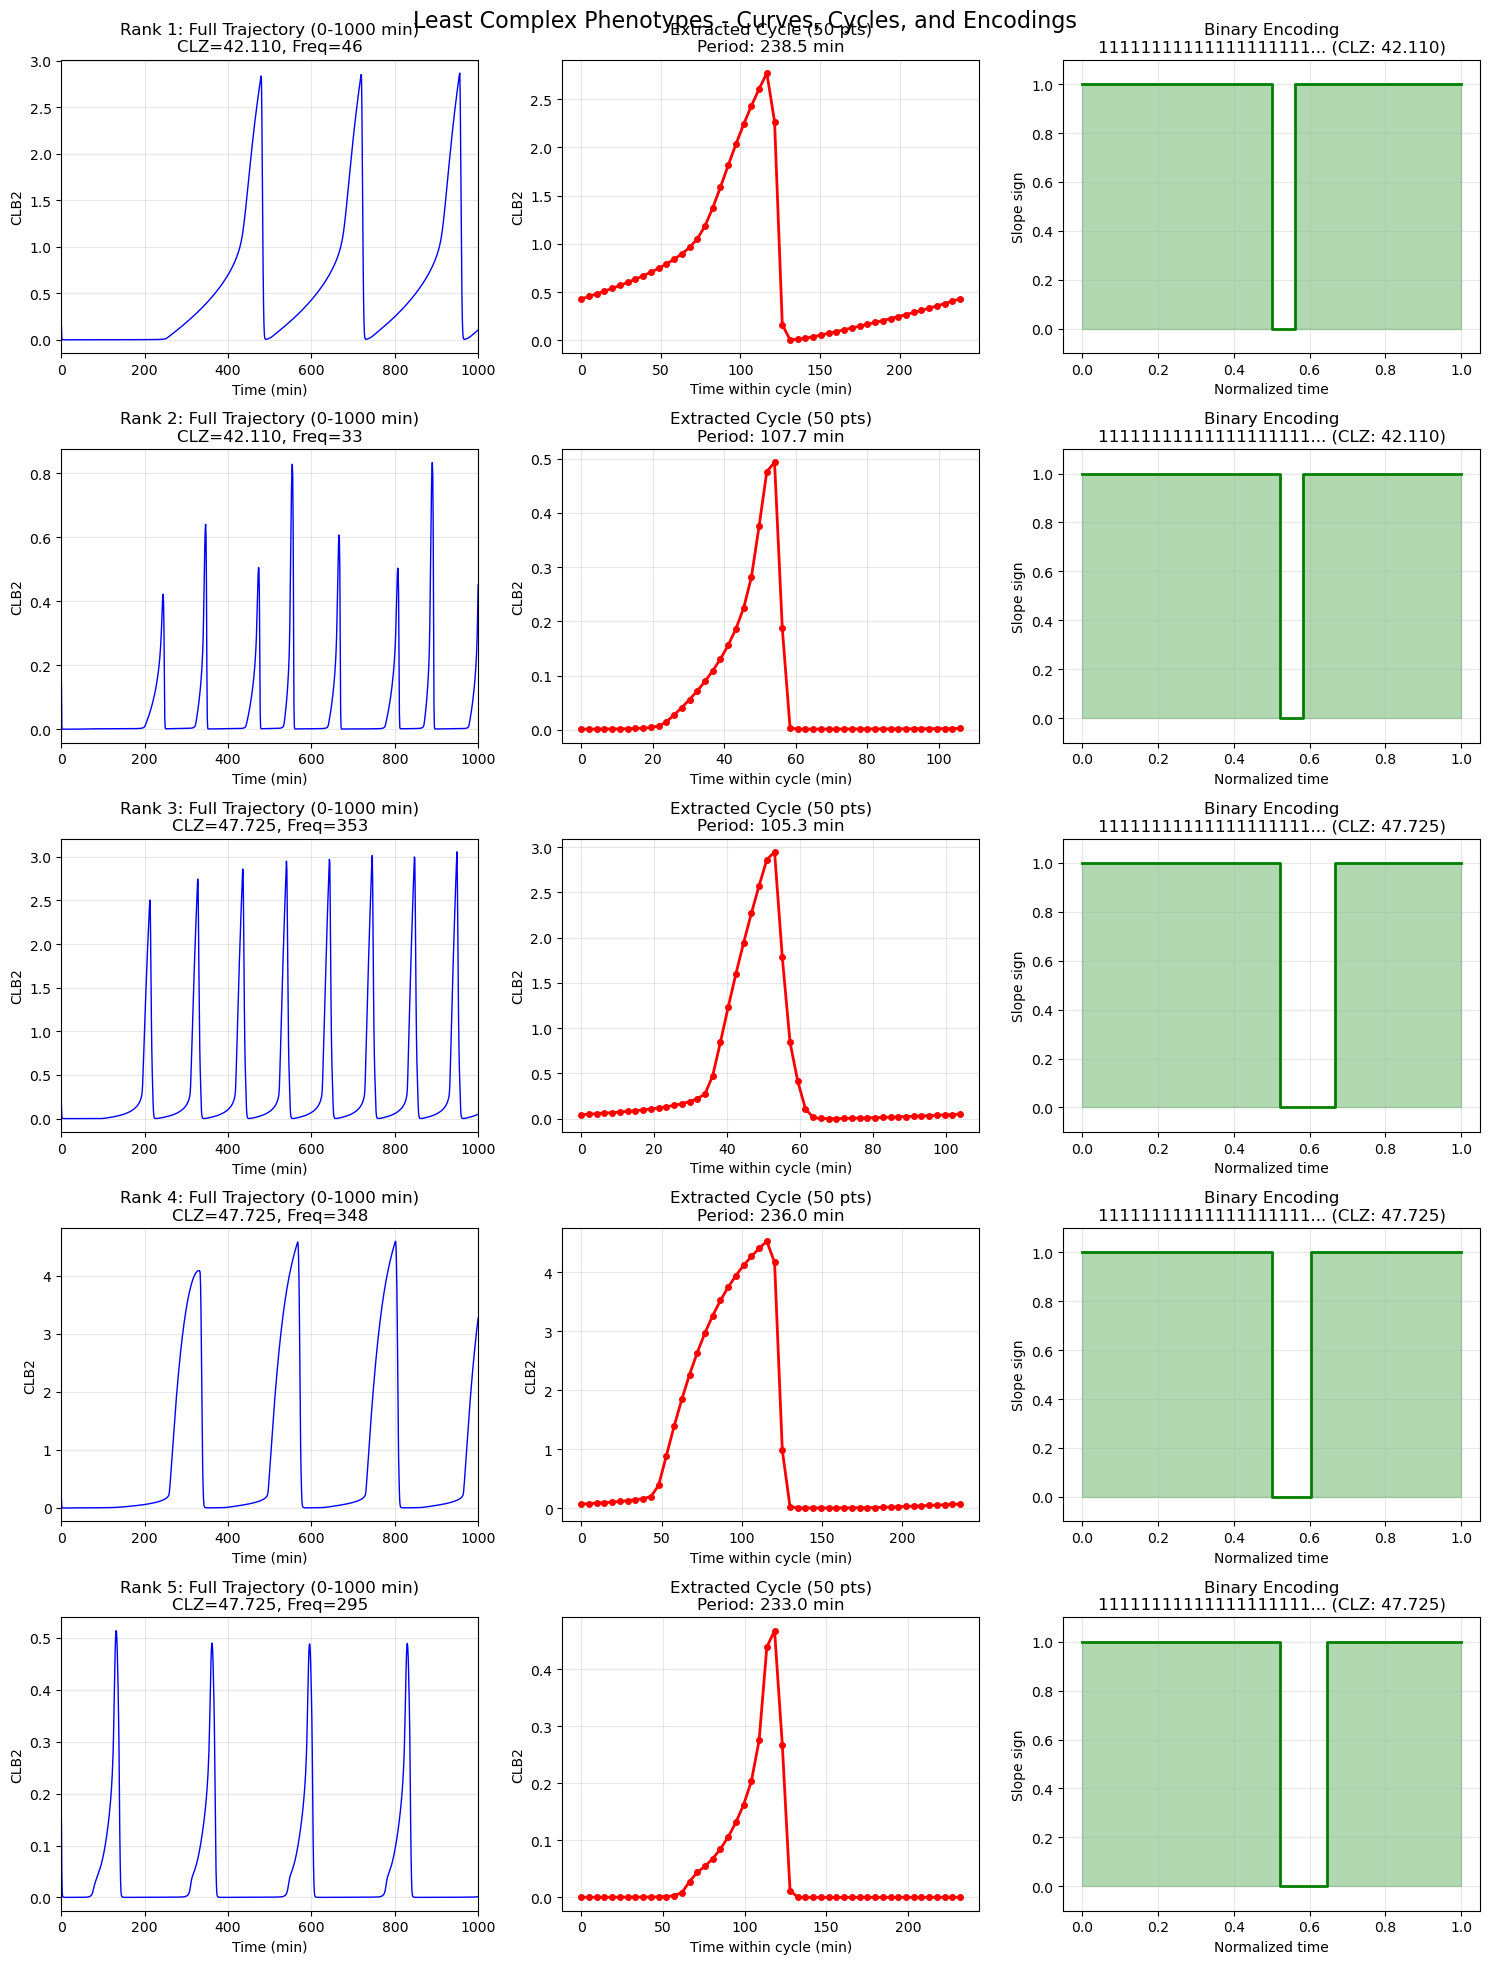

In [ ]:
def plot_tracked_phenotypes(tracked_data, title_prefix, plot_type):
    """Plot tracked phenotypes using stored genotype and phenotype data"""
    
    fig, axes = plt.subplots(5, 3, figsize=(15, 20))
    fig.suptitle(f"{title_prefix} Phenotypes - Curves, Cycles, and Encodings", fontsize=16, y=0.98)
    
    for i, (score, data_tuple) in enumerate(tracked_data):
        encoding, genotype, phenotype_data = data_tuple
        
        # Get stored data
        full_time = phenotype_data['full_time']
        full_clb2 = phenotype_data['full_clb2']
        period = phenotype_data['period']
        complexity = phenotype_data['complexity']
        
        # REGENERATE cycle data using the new improved period extraction method
        # This ensures we get the full-period-window cycles in the plots
        new_period, new_cycle_data = estimate_period(full_time, full_clb2)
        if new_cycle_data is not None and new_cycle_data[0] is not None:
            cycle_time, cycle_signal = new_cycle_data
            # Coarse-grain the new cycle to 50 points using safe function
            coarse_time, coarse_signal = safe_coarse_grain_to_50_steps(cycle_time, cycle_signal)
        else:
            coarse_time, coarse_signal = None, None
        
        # Fallback to stored data if regeneration fails
        if coarse_time is None or coarse_signal is None:
            coarse_time = phenotype_data.get('coarse_time', None)
            coarse_signal = phenotype_data.get('coarse_signal', None)
        
        # Get frequency from final count (with safety check)
        freq = phenotype_counts.get(encoding, 1) if 'phenotype_counts' in globals() else 1
        
        print(f"Plotting {title_prefix.lower()} phenotype {i+1}: freq={freq}, complexity={complexity:.3f}")
        
        # Plot 1: Full trajectory (FULL TIME from 0 to 1000 minutes)
        axes[i, 0].plot(full_time, full_clb2, 'b-', linewidth=1)
        
        if plot_type == "frequency":
            axes[i, 0].set_title(f"Rank {i+1}: Full Trajectory (0-1000 min)\nFreq={freq}, CLZ={complexity:.3f}")
        else:
            axes[i, 0].set_title(f"Rank {i+1}: Full Trajectory (0-1000 min)\nCLZ={complexity:.3f}, Freq={freq}")
        
        axes[i, 0].set_xlabel("Time (min)")
        axes[i, 0].set_ylabel("CLB2")
        axes[i, 0].set_xlim(0, 1000)  # Ensure we see the full time range
        axes[i, 0].grid(True, alpha=0.3)
        
        # Plot 2: Extracted cycle (50 points) - NOW USING NEW METHOD
        if coarse_time is not None and coarse_signal is not None:
            axes[i, 1].plot(coarse_time - coarse_time[0], coarse_signal, 'ro-', markersize=4, linewidth=2)
            axes[i, 1].set_title(f"Extracted Cycle ({len(coarse_time)} pts)\nPeriod: {period:.1f} min")
        else:
            axes[i, 1].text(0.5, 0.5, 'No cycle data\navailable', ha='center', va='center', 
                           transform=axes[i, 1].transAxes, fontsize=12)
            axes[i, 1].set_title(f"Extracted Cycle\nPeriod: {period:.1f} min")
        
        axes[i, 1].set_xlabel("Time within cycle (min)")
        axes[i, 1].set_ylabel("CLB2")
        axes[i, 1].grid(True, alpha=0.3)
        
        # Plot 3: Binary encoding (49 transitions)
        if len(encoding) > 0:
            step_time = np.linspace(0, 1, len(encoding))
            encoding_values = [int(bit) for bit in encoding]
            axes[i, 2].step(step_time, encoding_values, 'g-', linewidth=2, where='post')
            axes[i, 2].fill_between(step_time, 0, encoding_values, step='post', alpha=0.3, color='green')
            axes[i, 2].set_title(f"Binary Encoding\n{encoding[:20]}... (CLZ: {complexity:.3f})")
        else:
            axes[i, 2].text(0.5, 0.5, 'No encoding\navailable', ha='center', va='center', 
                           transform=axes[i, 2].transAxes, fontsize=12)
            axes[i, 2].set_title(f"Binary Encoding (CLZ: {complexity:.3f})")
        
        axes[i, 2].set_xlabel("Normalized time")
        axes[i, 2].set_ylabel("Slope sign")
        axes[i, 2].set_ylim(-0.1, 1.1)
        axes[i, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Check if we have tracking data and plot it
if success_count > 0 and 'tracker' in globals():
    # Get tracked phenotypes
    top_frequent = tracker.get_top_frequent()
    top_complex = tracker.get_top_complex()
    bottom_tracked = tracker.get_bottom_complex()
    
    print(f"Found {len(top_frequent)} top frequent phenotypes")
    print(f"Found {len(top_complex)} top complex phenotypes")
    print(f"Found {len(bottom_tracked)} bottom complex phenotypes")
    
    # Plot most frequent phenotypes
    if len(top_frequent) > 0:
        print("\nPlotting most frequent phenotypes...")
        plot_tracked_phenotypes(top_frequent, "Most Frequent", "frequency")
    
    # Plot most complex phenotypes  
    if len(top_complex) > 0:
        print("\nPlotting most complex phenotypes...")
        plot_tracked_phenotypes(top_complex, "Most Complex", "complexity")
    
    # Plot least complex phenotypes
    if len(bottom_tracked) > 0:
        print("\nPlotting least complex phenotypes...")
        plot_tracked_phenotypes(bottom_tracked, "Least Complex", "complexity")
        
else:
    print("No successful samples or tracker data to plot")
    print("Available variables:", [var for var in globals().keys() if not var.startswith('_')])

In [ ]:
# === TESTING IMPROVED PEAK DETECTION ===
print("=== COMPARING ORIGINAL vs IMPROVED PEAK DETECTION ===")

# Test both methods on a few examples
def test_peak_detection_methods(n_tests=10):
    """Compare original vs improved peak detection methods"""
    
    results_comparison = {
        'original_success': 0,
        'improved_success': 0,
        'both_success': 0,
        'both_fail': 0,
        'original_only': 0,
        'improved_only': 0,
        'period_differences': []
    }
    
    print(f"Testing {n_tests} random parameter sets...")
    print("Method comparison: Original vs Improved peak detection")
    print("-" * 60)
    
    for test_i in range(n_tests):
        # Generate random parameters
        rr_test = te.loadSBMLModel(model_path)
        sampled_params, sampled_values = sample_parameters(rr_test, wildtype=False)
        
        # Simulate
        full_time, full_clb2, period_orig, coarse_data_orig = simulate_and_extract_paper_method(rr_test)
        
        if isinstance(full_time, str):  # divergent or longperiod
            print(f"Test {test_i+1}: Skipped ({full_time})")
            continue
        
        if period_orig is None:
            print(f"Test {test_i+1}: Both methods failed (no oscillation)")
            results_comparison['both_fail'] += 1
            continue
        
        # Test original method directly
        period_orig_direct, cycle_data_orig_direct = estimate_period(full_time, full_clb2, center_on_peak=True, require_peaks=3)
        
        # Test improved method directly
        period_improved, cycle_data_improved = estimate_period_improved(full_time, full_clb2, center_on_peak=True, require_peaks=3)
        
        # Analyze results
        orig_success = period_orig_direct is not None
        improved_success = period_improved is not None
        
        if orig_success and improved_success:
            results_comparison['both_success'] += 1
            period_diff = abs(period_orig_direct - period_improved) / period_orig_direct * 100
            results_comparison['period_differences'].append(period_diff)
            status = f"Both OK (diff: {period_diff:.1f}%)"
        elif orig_success and not improved_success:
            results_comparison['original_only'] += 1
            status = "Original only"
        elif not orig_success and improved_success:
            results_comparison['improved_only'] += 1
            status = "Improved only"
        else:
            results_comparison['both_fail'] += 1
            status = "Both failed"
        
        results_comparison['original_success'] += int(orig_success)
        results_comparison['improved_success'] += int(improved_success)
        
        if orig_success and improved_success:
            print(f"Test {test_i+1}: {status} | Orig: {period_orig_direct:.1f}min | Improved: {period_improved:.1f}min")
        else:
            print(f"Test {test_i+1}: {status}")
    
    # Summary
    print("\n" + "="*60)
    print("PEAK DETECTION COMPARISON SUMMARY:")
    print("="*60)
    total_tests = results_comparison['original_success'] + results_comparison['improved_success'] + results_comparison['both_fail'] - results_comparison['both_success']
    
    print(f"Total valid tests: {total_tests}")
    print(f"Original method success rate: {results_comparison['original_success']}/{n_tests} ({results_comparison['original_success']/n_tests*100:.1f}%)")
    print(f"Improved method success rate: {results_comparison['improved_success']}/{n_tests} ({results_comparison['improved_success']/n_tests*100:.1f}%)")
    print()
    print(f"Both methods succeeded: {results_comparison['both_success']}")
    print(f"Only original succeeded: {results_comparison['original_only']}")
    print(f"Only improved succeeded: {results_comparison['improved_only']}")
    print(f"Both methods failed: {results_comparison['both_fail']}")
    
    if results_comparison['period_differences']:
        period_diffs = np.array(results_comparison['period_differences'])
        print(f"\nPeriod differences when both succeed:")
        print(f"  Mean difference: {np.mean(period_diffs):.1f}%")
        print(f"  Median difference: {np.median(period_diffs):.1f}%")
        print(f"  Max difference: {np.max(period_diffs):.1f}%")
    
    return results_comparison

# Run the comparison test
comparison_results = test_peak_detection_methods(15)

=== COMPARING ORIGINAL vs IMPROVED PEAK DETECTION ===
Testing 15 random parameter sets...
Method comparison: Original vs Improved peak detection
------------------------------------------------------------
Test 1: Skipped (divergent)
Test 2: Skipped (divergent)
Test 3: Skipped (divergent)
Test 4: Skipped (divergent)
Test 5: Skipped (divergent)
Test 6: Skipped (divergent)
Test 7: Both methods failed (no oscillation)
Test 4: Skipped (divergent)
Test 5: Skipped (divergent)
Test 6: Skipped (divergent)
Test 7: Both methods failed (no oscillation)
Test 8: Skipped (divergent)
Test 9: Skipped (divergent)
Test 10: Skipped (divergent)
Test 11: Skipped (divergent)
Test 8: Skipped (divergent)
Test 9: Skipped (divergent)
Test 10: Skipped (divergent)
Test 11: Skipped (divergent)
Test 12: Skipped (divergent)
Test 13: Skipped (divergent)
Test 14: Skipped (divergent)
Test 15: Skipped (divergent)

PEAK DETECTION COMPARISON SUMMARY:
Total valid tests: 1
Original method success rate: 0/15 (0.0%)
Improved 

In [ ]:
# === COMPREHENSIVE PEAK DETECTION COMPARISON ===
print("=== COMPREHENSIVE COMPARISON: Testing more samples ===")

def comprehensive_peak_test(n_tests=50):
    """More comprehensive test of peak detection methods"""
    
    print(f"Testing {n_tests} random parameter sets with both methods...")
    
    original_successes = []
    improved_successes = []
    divergent_count = 0
    longperiod_count = 0
    
    for i in range(n_tests):
        if (i + 1) % 10 == 0:
            print(f"  Progress: {i+1}/{n_tests} tests completed...")
        
        # Generate and test
        rr_test = te.loadSBMLModel(model_path)
        sampled_params, sampled_values = sample_parameters(rr_test, wildtype=False)
        
        # Get raw simulation data
        try:
            rr_test.selections = ["time", "CLB2"]
            result = rr_test.simulate(0, SIMULATION_TIME, SIMULATION_POINTS)
            time = result[:, 0]
            clb2 = result[:, 1]
            
            # Check for divergence
            if ENABLE_FAST_REJECT and check_divergence_fast(clb2, DIVERGENCE_THRESHOLD):
                divergent_count += 1
                continue
                
        except RuntimeError:
            divergent_count += 1
            continue
        
        # Test both methods on the same data
        period_orig, cycle_orig = estimate_period(time, clb2, center_on_peak=True, require_peaks=3)
        period_improved, cycle_improved = estimate_period_improved(time, clb2, center_on_peak=True, require_peaks=3)
        
        # Check for long periods
        if period_orig is not None and period_orig > MAX_PERIOD_THRESHOLD:
            longperiod_count += 1
            period_orig = None
        if period_improved is not None and period_improved > MAX_PERIOD_THRESHOLD:
            period_improved = None
        
        original_successes.append(period_orig is not None)
        improved_successes.append(period_improved is not None)
    
    # Calculate statistics
    orig_success_rate = sum(original_successes) / len(original_successes) * 100
    improved_success_rate = sum(improved_successes) / len(improved_successes) * 100
    
    both_success = sum(1 for o, i in zip(original_successes, improved_successes) if o and i)
    orig_only = sum(1 for o, i in zip(original_successes, improved_successes) if o and not i)
    improved_only = sum(1 for o, i in zip(original_successes, improved_successes) if i and not o)
    both_fail = sum(1 for o, i in zip(original_successes, improved_successes) if not o and not i)
    
    print(f"\n{'='*70}")
    print("COMPREHENSIVE PEAK DETECTION RESULTS:")
    print(f"{'='*70}")
    print(f"Total tests run: {n_tests}")
    print(f"Divergent solutions: {divergent_count}")
    print(f"Long period solutions: {longperiod_count}")
    print(f"Valid tests analyzed: {len(original_successes)}")
    print()
    print(f"Original method success rate: {sum(original_successes)}/{len(original_successes)} ({orig_success_rate:.1f}%)")
    print(f"Improved method success rate: {sum(improved_successes)}/{len(improved_successes)} ({improved_success_rate:.1f}%)")
    print()
    print("Detailed breakdown:")
    print(f"  Both methods succeeded: {both_success}")
    print(f"  Only original succeeded: {orig_only}")
    print(f"  Only improved succeeded: {improved_only}")
    print(f"  Both methods failed: {both_fail}")
    print()
    
    if improved_success_rate > orig_success_rate:
        improvement = improved_success_rate - orig_success_rate
        print(f"🎉 IMPROVED METHOD PERFORMS BETTER!")
        print(f"   Success rate improvement: +{improvement:.1f} percentage points")
        print(f"   Additional successful detections: {improved_only}")
    elif orig_success_rate > improved_success_rate:
        decline = orig_success_rate - improved_success_rate
        print(f"⚠️  Original method performs better")
        print(f"   Success rate decline: -{decline:.1f} percentage points")
    else:
        print(f"🤝 Both methods perform equally well")
    
    return {
        'original_rate': orig_success_rate,
        'improved_rate': improved_success_rate,
        'both_success': both_success,
        'orig_only': orig_only,
        'improved_only': improved_only,
        'both_fail': both_fail
    }

# Run comprehensive test
print("🔬 Running comprehensive peak detection comparison...")
comp_results = comprehensive_peak_test(50)

=== COMPREHENSIVE COMPARISON: Testing more samples ===
🔬 Running comprehensive peak detection comparison...
Testing 50 random parameter sets with both methods...
  Progress: 10/50 tests completed...
  Progress: 10/50 tests completed...
  Progress: 20/50 tests completed...
  Progress: 20/50 tests completed...
  Progress: 30/50 tests completed...
  Progress: 30/50 tests completed...
  Progress: 40/50 tests completed...
  Progress: 40/50 tests completed...
  Progress: 50/50 tests completed...

COMPREHENSIVE PEAK DETECTION RESULTS:
Total tests run: 50
Divergent solutions: 35
Long period solutions: 0
Valid tests analyzed: 15

Original method success rate: 5/15 (33.3%)
Improved method success rate: 10/15 (66.7%)

Detailed breakdown:
  Both methods succeeded: 5
  Only original succeeded: 0
  Only improved succeeded: 5
  Both methods failed: 5

🎉 IMPROVED METHOD PERFORMS BETTER!
   Success rate improvement: +33.3 percentage points
   Additional successful detections: 5
  Progress: 50/50 tests 

=== VISUAL COMPARISON: Finding examples where methods differ ===
Searching for examples where the methods differ...
  Found difference #1: improved_only
  Found difference #1: improved_only
  Found difference #2: improved_only
  Found difference #2: improved_only
  Found difference #3: improved_only
Found 3 interesting cases after 64 attempts
  Found difference #3: improved_only
Found 3 interesting cases after 64 attempts


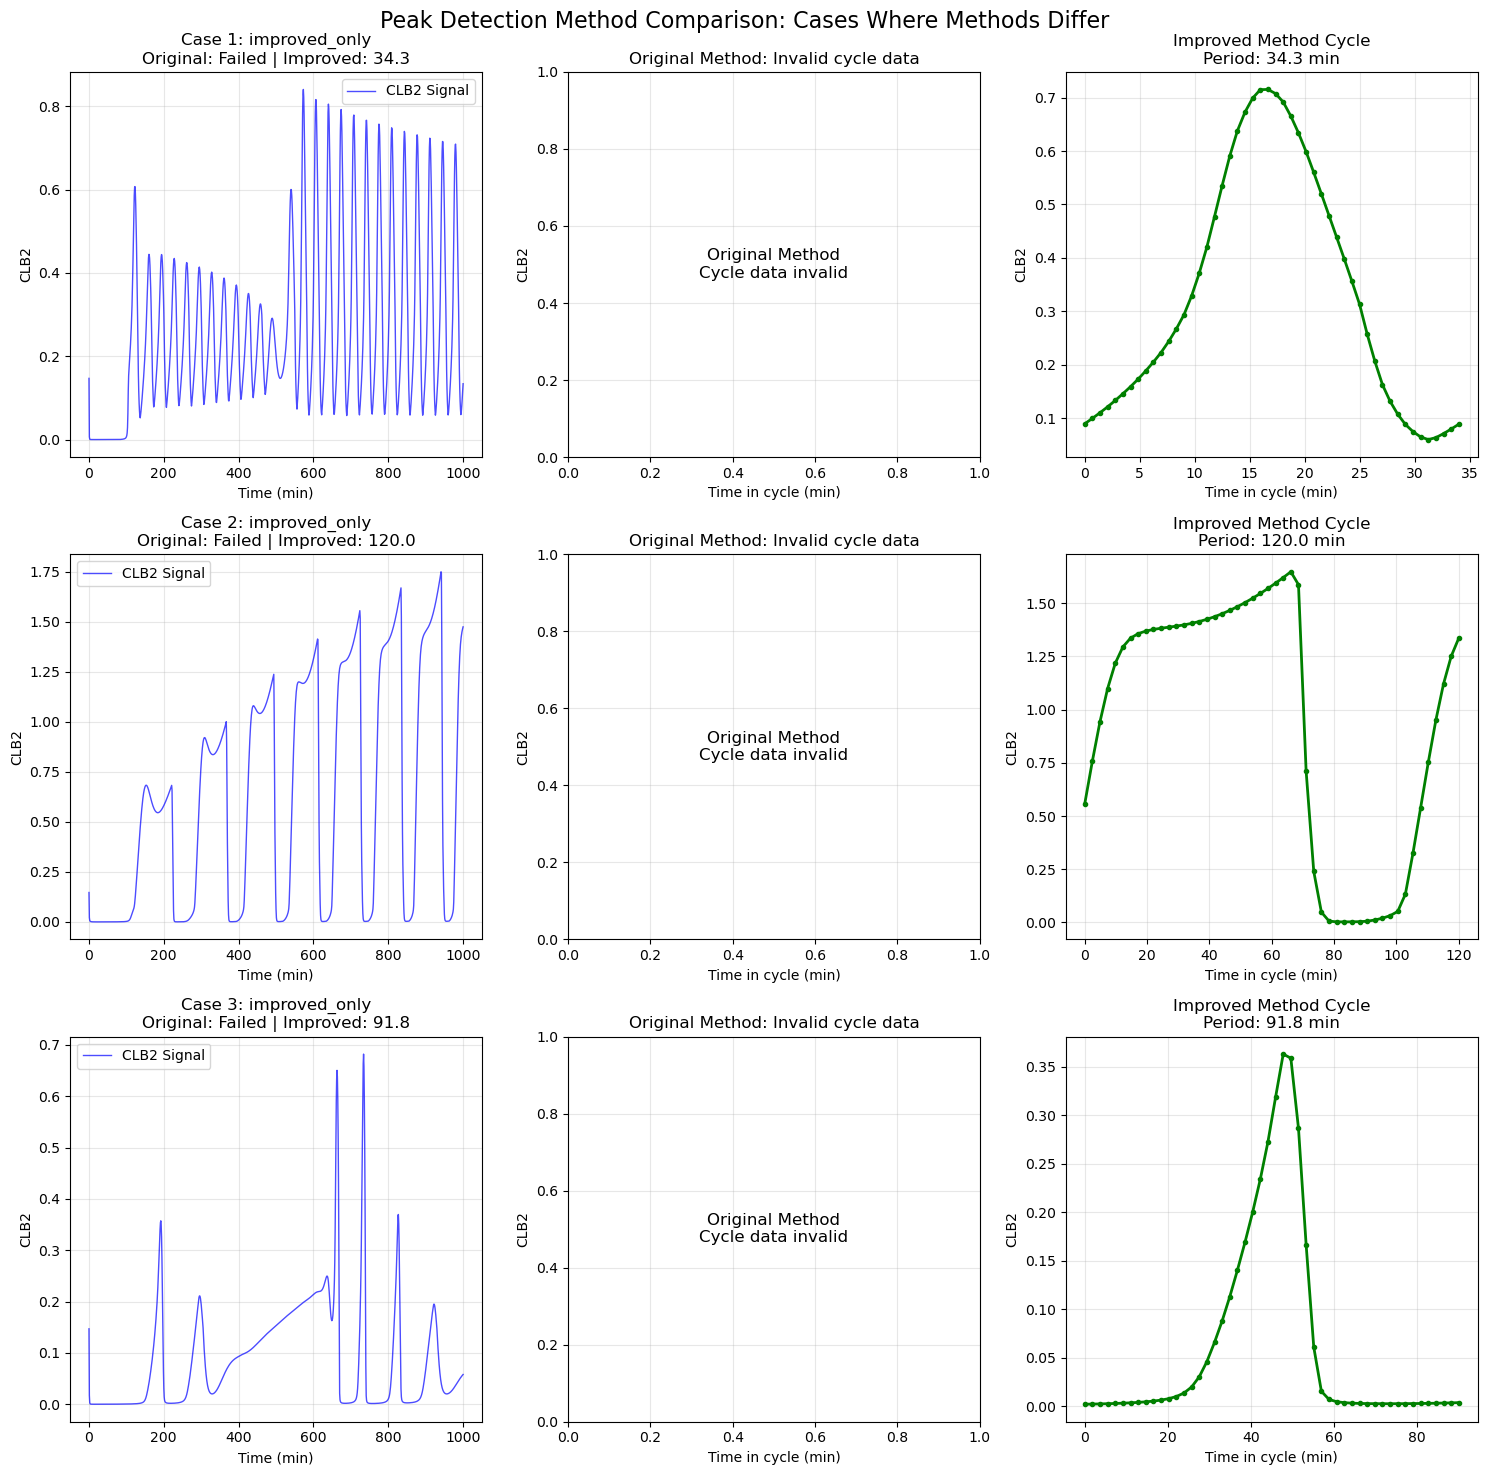


Visualization saved as: plots/peak_detection_method_comparison.png


In [ ]:
# === VISUAL COMPARISON OF PEAK DETECTION METHODS ===
print("=== VISUAL COMPARISON: Finding examples where methods differ ===")

def find_and_visualize_differences():
    """Find cases where original and improved methods give different results and visualize them"""
    
    differences_found = []
    attempts = 0
    max_attempts = 100
    
    print("Searching for examples where the methods differ...")
    
    while len(differences_found) < 3 and attempts < max_attempts:
        attempts += 1
        
        # Generate test case
        rr_test = te.loadSBMLModel(model_path)
        sampled_params, sampled_values = sample_parameters(rr_test, wildtype=False)
        
        try:
            rr_test.selections = ["time", "CLB2"]
            result = rr_test.simulate(0, SIMULATION_TIME, SIMULATION_POINTS)
            time = result[:, 0]
            clb2 = result[:, 1]
            
            # Skip divergent
            if ENABLE_FAST_REJECT and check_divergence_fast(clb2, DIVERGENCE_THRESHOLD):
                continue
                
        except RuntimeError:
            continue
        
        # Test both methods
        period_orig, cycle_orig = estimate_period(time, clb2, center_on_peak=True, require_peaks=3)
        period_improved, cycle_improved = estimate_period_improved(time, clb2, center_on_peak=True, require_peaks=3)
        
        # Look for interesting differences
        orig_success = period_orig is not None
        improved_success = period_improved is not None
        
        if orig_success != improved_success:  # Different outcomes
            differences_found.append({
                'time': time,
                'clb2': clb2,
                'period_orig': period_orig,
                'period_improved': period_improved,
                'cycle_orig': cycle_orig,
                'cycle_improved': cycle_improved,
                'sampled_values': sampled_values,
                'case_type': 'improved_only' if improved_success and not orig_success else 'original_only'
            })
            print(f"  Found difference #{len(differences_found)}: {differences_found[-1]['case_type']}")
        
        elif orig_success and improved_success:  # Both succeed - check period difference
            period_diff_pct = abs(period_orig - period_improved) / period_orig * 100
            if period_diff_pct > 20:  # Significant difference
                differences_found.append({
                    'time': time,
                    'clb2': clb2,
                    'period_orig': period_orig,
                    'period_improved': period_improved,
                    'cycle_orig': cycle_orig,
                    'cycle_improved': cycle_improved,
                    'sampled_values': sampled_values,
                    'case_type': f'both_differ_{period_diff_pct:.1f}pct'
                })
                print(f"  Found difference #{len(differences_found)}: period differs by {period_diff_pct:.1f}%")
    
    print(f"Found {len(differences_found)} interesting cases after {attempts} attempts")
    
    # Visualize the differences
    if differences_found:
        n_cases = len(differences_found)
        fig, axes = plt.subplots(n_cases, 3, figsize=(15, 5*n_cases))
        if n_cases == 1:
            axes = axes.reshape(1, -1)
        
        fig.suptitle("Peak Detection Method Comparison: Cases Where Methods Differ", fontsize=16)
        
        for i, case in enumerate(differences_found):
            time = case['time']
            clb2 = case['clb2']
            
            # Plot 1: Full trajectory with detected peaks
            axes[i, 0].plot(time, clb2, 'b-', linewidth=1, alpha=0.7, label='CLB2 Signal')
            
            # Show original peaks if available
            if case['period_orig'] is not None:
                try:
                    # Re-run original method to get peak locations
                    from scipy.signal import find_peaks
                    dynamic_prom = 0.05 * (np.max(clb2) - np.min(clb2))
                    peaks_orig, _ = find_peaks(clb2, prominence=dynamic_prom, distance=len(time)//100)
                    if len(peaks_orig) > 0:
                        axes[i, 0].scatter(time[peaks_orig], clb2[peaks_orig], color='red', s=30, 
                                         marker='o', label=f'Original peaks ({len(peaks_orig)})', zorder=5)
                except:
                    pass
            
            # Show improved peaks if available
            if case['period_improved'] is not None:
                # Note: The improved method's internal peak detection is complex, 
                # so we'll just indicate success with a title
                pass
            
            # Fix the string formatting issue by handling None values properly
            orig_str = f"{case['period_orig']:.1f}" if case['period_orig'] is not None else "Failed"
            improved_str = f"{case['period_improved']:.1f}" if case['period_improved'] is not None else "Failed"
            
            axes[i, 0].set_title(f"Case {i+1}: {case['case_type']}\nOriginal: {orig_str} | Improved: {improved_str}")
            axes[i, 0].set_xlabel("Time (min)")
            axes[i, 0].set_ylabel("CLB2")
            axes[i, 0].legend()
            axes[i, 0].grid(True, alpha=0.3)
            
            # Plot 2: Original method cycle (if available)
            if case['cycle_orig'] is not None and len(case['cycle_orig']) == 2:
                coarse_time_orig, coarse_signal_orig = case['cycle_orig']
                if coarse_time_orig is not None and coarse_signal_orig is not None:
                    axes[i, 1].plot(coarse_time_orig - coarse_time_orig[0], coarse_signal_orig, 
                                  'ro-', markersize=3, linewidth=2, label='Original')
                    axes[i, 1].set_title(f"Original Method Cycle\nPeriod: {case['period_orig']:.1f} min")
                else:
                    axes[i, 1].text(0.5, 0.5, 'Original Method\nCycle data invalid', 
                                  ha='center', va='center', transform=axes[i, 1].transAxes, fontsize=12)
                    axes[i, 1].set_title("Original Method: Invalid cycle data")
            else:
                axes[i, 1].text(0.5, 0.5, 'Original Method\nFailed', 
                              ha='center', va='center', transform=axes[i, 1].transAxes, fontsize=12)
                axes[i, 1].set_title("Original Method: Failed")
            
            axes[i, 1].set_xlabel("Time in cycle (min)")
            axes[i, 1].set_ylabel("CLB2")
            axes[i, 1].grid(True, alpha=0.3)
            
            # Plot 3: Improved method cycle (if available)
            if case['cycle_improved'] is not None and len(case['cycle_improved']) == 2:
                coarse_time_improved, coarse_signal_improved = case['cycle_improved']
                if coarse_time_improved is not None and coarse_signal_improved is not None:
                    axes[i, 2].plot(coarse_time_improved - coarse_time_improved[0], coarse_signal_improved, 
                                  'go-', markersize=3, linewidth=2, label='Improved')
                    axes[i, 2].set_title(f"Improved Method Cycle\nPeriod: {case['period_improved']:.1f} min")
                else:
                    axes[i, 2].text(0.5, 0.5, 'Improved Method\nCycle data invalid', 
                                  ha='center', va='center', transform=axes[i, 2].transAxes, fontsize=12)
                    axes[i, 2].set_title("Improved Method: Invalid cycle data")
            else:
                axes[i, 2].text(0.5, 0.5, 'Improved Method\nFailed', 
                              ha='center', va='center', transform=axes[i, 2].transAxes, fontsize=12)
                axes[i, 2].set_title("Improved Method: Failed")
            
            axes[i, 2].set_xlabel("Time in cycle (min)")
            axes[i, 2].set_ylabel("CLB2")
            axes[i, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig("plots/peak_detection_method_comparison.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\nVisualization saved as: plots/peak_detection_method_comparison.png")
        
    else:
        print("No significant differences found between methods in this sample.")
    
    return differences_found

# Run the visual comparison
visual_examples = find_and_visualize_differences()